# [Lecture 15 - Social Networks](https://youtu.be/hnYhJzYAQ60?si=Y9bnH_DopygCafIr)

In [1]:
%run init_notebook.py

Module aliases imported by init_notebook.py:
--------------------------------------------
import numpy as np

import pandas as pd

import statsmodels.formula.api as smf

import pymc as pm

import xarray as xr

import arviz as az

import utils as utils

from scipy import stats as stats

from matplotlib import pyplot as plt

Watermark:
----------
Last updated: 2024-06-23T17:25:51.507191+09:00

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.25.0

Compiler    : GCC 12.3.0
OS          : Linux
Release     : 6.6.25-01713-g2f237acc8e50
Machine     : x86_64
Processor   : 
CPU cores   : 4
Architecture: 64bit

pymc       : 5.15.1
statsmodels: 0.14.2
pandas     : 2.2.2
numpy      : 1.26.4
xarray     : 2024.6.0
arviz      : 0.18.0
matplotlib : 3.8.4
scipy      : 1.13.1



In [2]:
import pymc as pm
import arviz as az
import numpy as np
import networkx as nx
from scipy import stats as stats

# What Motivates Sharing?

## Koster & Leckie (2014) Arang Dak dataset
- year of food transfers between 25 households
- 300 dyads, i.e. $\binom{25}{2} = 300$
- 2871 observations of food transfers ("gifts")

### Scientific Questions: Estimand(s)
- How much sharing is explained by **reciprocity?**
- How much by **generalized giving?**


In [3]:
SHARING = utils.load_data('KosterLeckie')
SHARING.head()

,hidA,hidB,did,giftsAB,giftsBA,offset,drel1,drel2,drel3,drel4,dlndist,dass,d0125
0,1,2,1,0,4,0.000,0,0,1,0,-2.790,0.000,0
1,1,3,2,6,31,-0.003,0,1,0,0,-2.817,0.044,0
2,1,4,3,2,5,-0.019,0,1,0,0,-1.886,0.025,0
3,1,5,4,4,2,0.000,0,1,0,0,-1.892,0.011,0
4,1,6,5,8,2,-0.003,1,0,0,0,-3.499,0.022,0


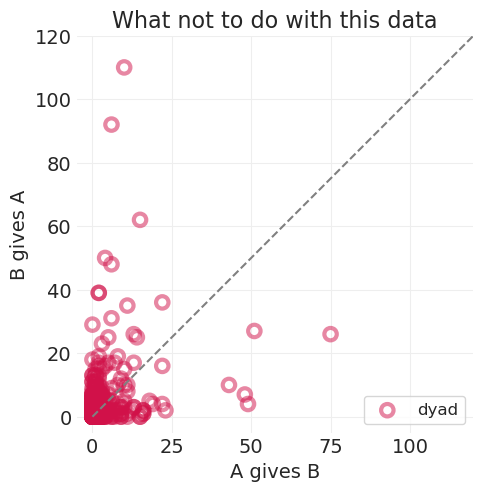

In [4]:
utils.plot_scatter(
    SHARING.giftsAB,
    SHARING.giftsBA,
    color='C0',
    label='dyad',
    alpha=.5
)
plt.plot((0, 120), (0, 120), linestyle='--', color='gray')
plt.axis('square')
plt.xlabel("A gives B")
plt.ylabel("B gives A")
plt.xlim([-5, 120])
plt.ylim([-5, 120])
plt.title("What not to do with this data");
plt.legend();

## Improve analysis with a causal graph

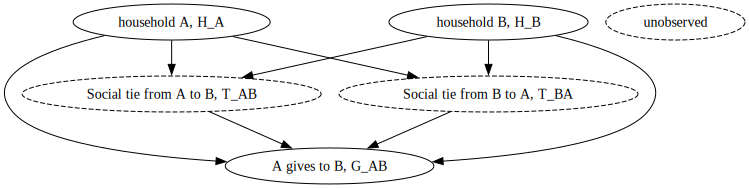

In [4]:
utils.draw_causal_graph(
    edge_list=[
        ("H_A", "G_AB"),
        ("H_B", "G_AB"),
        ("H_A", "T_AB"),
        ("H_B", "T_AB"),
        ("H_A", "T_BA"),
        ("H_B", "T_BA"),
        ("T_AB", "G_AB"),
        ("T_BA", "G_AB"),
    ],
    node_props={
        "H_A": {"label": "household A, H_A"},
        "H_B": {"label": "household B, H_B"},
        "G_AB": {"label": "A gives to B, G_AB"},
        "T_AB": {"label": "Social tie from A to B, T_AB", "style": "dashed"},
        "T_BA": {"label": "Social tie from B to A, T_BA", "style": "dashed"},
        "unobserved": {"style": "dashed"},
    }
    
)

## Social Network Analysis
- $T_{AB}$ and $T_{BA}$ are not observable
- **Social network** is Pattern of direct exchange
- Social network is **an abstraction, not data**
- what's a principled approach?
  - bad approach -> Null network analysis
    - no correct way to permute
    - we care about causality, not testing a null hypothesis
    
    
## Drawing the Social Owl 🦉
1. Estimand(s): Reciprocity & what explains it
2. Generative model
3. Statistical model
4. Analyze data

We'll loop between 2 and 3 often as we build the complexity of our model

## 1) Estimand
### Starting Simpler, ignoring household effects for now

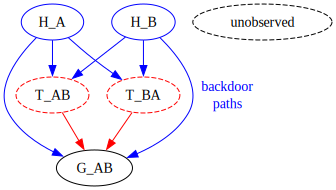

In [5]:
utils.draw_causal_graph(
    edge_list=[
        ("H_A", "G_AB"),
        ("H_B", "G_AB"),
        ("H_A", "T_AB"),
        ("H_B", "T_AB"),
        ("H_A", "T_BA"),
        ("H_B", "T_BA"),
        ("T_AB", "G_AB"),
        ("T_BA", "G_AB"),
    ],
    node_props={
        "H_A": {"color": "blue"},
        "H_B": {"color": "blue"},
        "T_AB": {"style": "dashed", "color": "red"},
        "T_BA": {"style": "dashed", "color": "red"},
        "unobserved": {"style": "dashed"},
    },
    edge_props={
        ("T_AB", "G_AB"): {"color": "red"},
        ("T_BA", "G_AB"): {"color": "red"},
        ("H_A", "G_AB"): {"color": "blue"},
        ("H_B", "G_AB"): {"color": "blue", "label": " backdoor\npaths", "fontcolor": "blue"},
        ("H_A", "T_AB"): {"color": "blue"},
        ("H_A", "T_BA"): {"color": "blue"},
        ("H_B", "T_AB"): {"color": "blue"},
        ("H_B", "T_BA"): {"color": "blue"},
    }
    
)

At first, we'll ignore the backdoor paths to get a good flow, and get the model running, then add them in later

## 2) Generative Model
### Simulating a Social Network

In [4]:
from itertools import combinations
np.random.seed(123)

N = 25
dyads = list(combinations(np.arange(N), 2))

# convert to numpy for np.where 
DYADS = np.array(dyads)
N_DYADS = len(DYADS)

print(f"N dyads: {N_DYADS}")
print(dyads[:91])

N dyads: 300
[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (3, 23), (3, 24), (4, 5)]


In [5]:
# Simulate "friendship", in which ties are shared
P_FRIENDSHIP = 0.1
FRIENDSHIP = stats.bernoulli(p=P_FRIENDSHIP).rvs(size=N_DYADS)

In [6]:
# Simulate directed ties. Note: there can be ties that are not reciprocal
ALPHA = -3. # base rate has low probability
BASE_TIE_PROBABILITY = utils.invlogit(ALPHA)
print(f"\nBase non-friend social tie probability: {BASE_TIE_PROBABILITY:.2}")


Base non-friend social tie probability: 0.047


In [7]:
# Function to get the index of a dyad (pair of individuals) in the DYADS array
def get_dyad_index(source, target):
    # dyads are symmetric, but ordered by definition,
    # so ensure valid lookup by sorting
    ii, jj = sorted([source, target])
    return np.where((DYADS[:, 0] == ii) & (DYADS[:, 1] == jj))[0][0]

# Simulate gift-giving ties
TIES = np.zeros((N, N)).astype(int)

for source in range(N):
    for target in range(N):
        if source != target:
            dyad_index = get_dyad_index(source, target)
            # Sample directed edge -- friends always share ties,
            # but there's also a base rate of sharing ties w/o friendship
            is_friend = FRIENDSHIP[dyad_index]
            p_tie = is_friend + (1 - is_friend) * BASE_TIE_PROBABILITY
            TIES[source, target] = stats.bernoulli(p_tie).rvs()

In [14]:
TIES

array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
        0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
      

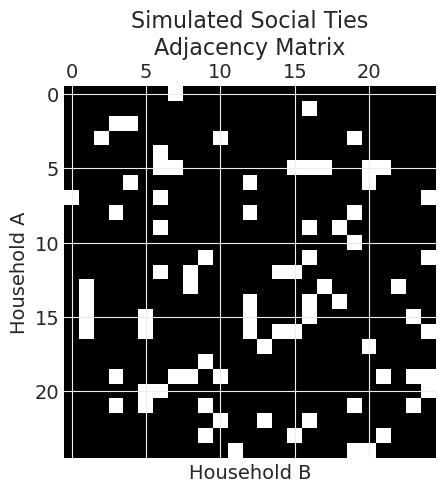

In [79]:
plt.matshow(TIES, cmap='gray')
plt.ylabel("Household A")
plt.xlabel("Household B")
plt.title("Simulated Social Ties\nAdjacency Matrix");

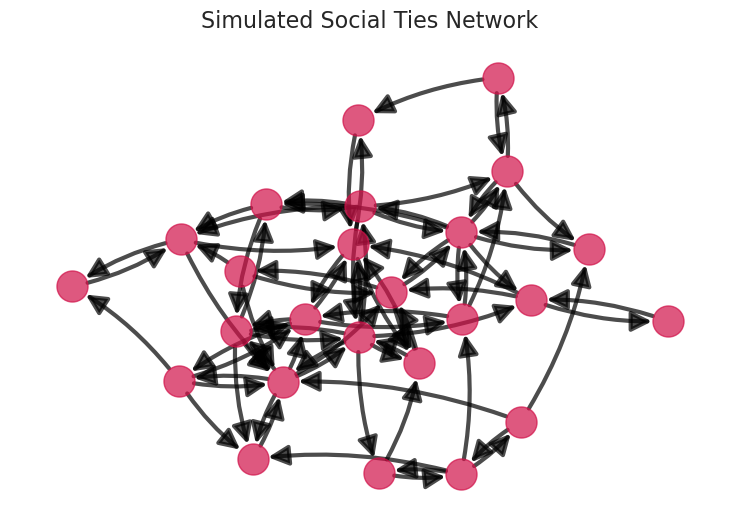

In [80]:
import networkx as nx
TIES_LAYOUT_POSITION = utils.plot_graph(TIES)
plt.title("Simulated Social Ties Network");

### Simulate Gift-giving from social net

In [81]:
giftsAB = np.zeros(N_DYADS)
giftsBA = np.zeros(N_DYADS)
lam = np.log([0.5, 2])

for ii, (A, B) in enumerate(DYADS):
    # put lambad=1 if there is a tie an 0 is none
    lambdaAB = np.exp(lam[TIES[A, B]])
    giftsAB[ii] = stats.poisson(mu=lambdaAB).rvs()
    
    lambdaBA = np.exp(lam[TIES[B, A]])
    giftsBA[ii] = stats.poisson(mu=lambdaBA).rvs()
    
## Put simulation into a dataframe for fitting function
simulated_gifts = pd.DataFrame(
    {
        "giftsAB": giftsAB.astype(int),
        "giftsBA": giftsBA.astype(int),
        "did": np.arange(N_DYADS).astype(int)
    }
)

simulated_gifts

,giftsAB,giftsBA,did
0,1,0,0
1,0,1,1
2,2,0,2
3,0,1,3
4,0,0,4
...,...,...,...
295,0,1,295
296,0,0,296
297,1,0,297
298,0,0,298


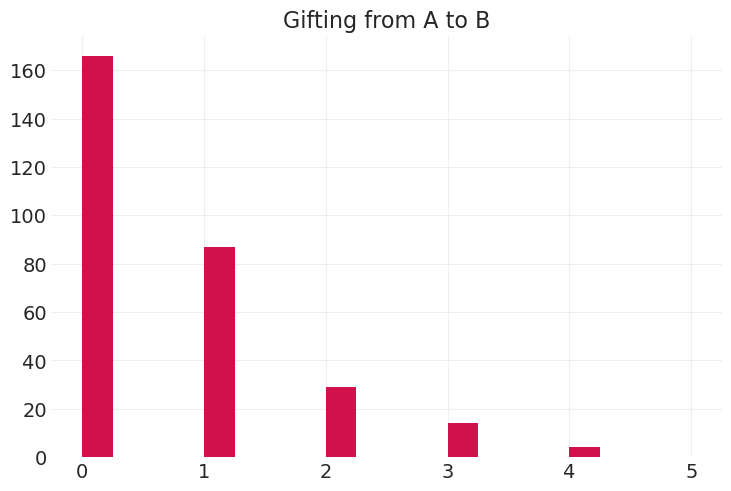

In [16]:
plt.hist(simulated_gifts.giftsAB, bins=simulated_gifts.giftsAB.max(), width=.25);
plt.title("Gifting from A to B");

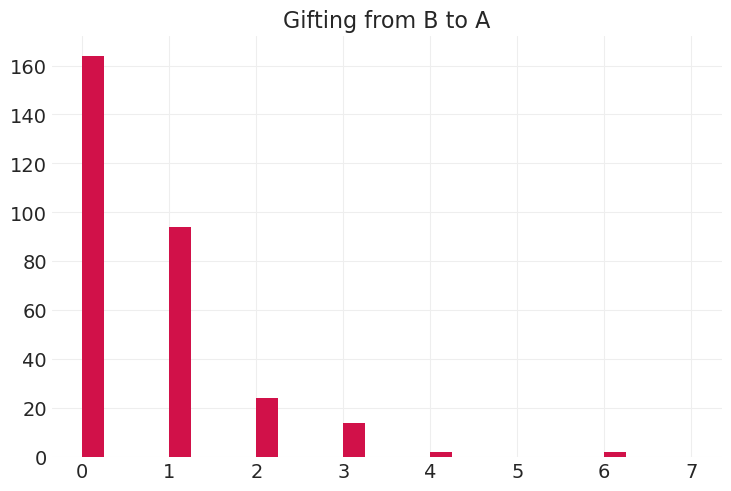

In [17]:
plt.hist(simulated_gifts.giftsBA, bins=simulated_gifts.giftsBA.max(), width=.25);
plt.title("Gifting from B to A");

## 3) Statistical Model

#### Likelihood
$$
\begin{align*}
    G_{AB} &\sim \text{Poisson}(\lambda_{AB}) \\
    G_{BA} &\sim \text{Poisson}(\lambda_{BA}) \\
    \log(\lambda_{AB}) &= \alpha + T_{AB} \\
    \log(\lambda_{BA}) &= \alpha + T_{BA} \\
\end{align*}
$$

#### Global gift-giving prior
$$
\alpha \sim \text{Normal}(0, 1) \\
$$

#### Correlated Social Ties prior
$$
\begin{align*}
    \begin{pmatrix}
    T_{AB} \\
    T_{BA}
    \end{pmatrix} &= \text{MVNormal}
    \left( 
        \begin{bmatrix}
            0 \\
            0
        \end{bmatrix},
        \begin{bmatrix}
            \sigma^2 & \rho \sigma^2 \\
            \rho \sigma^2 & \sigma^2
        \end{bmatrix}
    \right) \\
    \rho &\sim \text{LKJCorr}(\eta) \\
    \sigma &\sim \text{Exponential}(1)
\end{align*}
$$

- Symmetric Likelihood
- Global intercept, but tie-specific offset
- We model the (symmetric) correlation between social $T_{AB}, T_{BA}$ 
- Priors give us **partial pooling**, allowing us to share information from ties that have a lot of activity to those ties that have less activity

### Fitting the social ties model
##### Notes
- We use `LKJCholeskyCov` instead of `LKJCorr` for numerical stability/efficiency

In [88]:
# Original model function
def fit_social_ties_model(data, eta=4):
    n_dyads = len(data)
    
    # ensure zero-indexed IDs
    dyad_id = data.did.values.astype(int)
    if np.min(dyad_id) == 1:
        dyad_id -= 1
    
    n_correlated_features = 2

    with pm.Model() as model:
        
        # Single, global alpha
        alpha = pm.Normal("alpha", 0, 1)
        
        # Single, global sigma
        sigma = pm.Exponential.dist(1)
        chol, corr, stds = pm.LKJCholeskyCov(
            "rho",
            eta=eta,
            n=n_correlated_features,
            sd_dist=sigma
        )
        
        # Record quantities for reporting
        pm.Deterministic("corrcoef_T", corr[0, 1])
        pm.Deterministic("std_T", stds)

        z = pm.Normal("z", 0, 1, shape=(n_dyads, n_correlated_features))
        T = pm.Deterministic("T", chol.dot(z.T).T)

        # Likelihood(s)
        lambda_AB = pm.Deterministic("lambda_AB", pm.math.exp(alpha + T[dyad_id, 0]))
        lambda_BA = pm.Deterministic("lambda_BA", pm.math.exp(alpha + T[dyad_id, 1]))

        G_AB = pm.Poisson("G_AB", lambda_AB, observed=data.giftsAB)
        G_BA = pm.Poisson("G_BA", lambda_BA, observed=data.giftsBA)

        inference = pm.sample(tune=2000,
                              draws=2000,
                              chains=4,
                              nuts_sampler='numpyro',
                            target_accept=.9)
    return model, inference

In [89]:
simulated_social_ties_model, simulated_social_ties_inference = fit_social_ties_model(simulated_gifts, eta=2)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [90]:
az.summary(simulated_social_ties_inference, var_names='rho_corr')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"rho_corr[0, 0]",1.000,0.00,1.000,1.000,0.000,0.000,8000.0,8000.0,NaN
"rho_corr[0, 1]",0.597,0.19,0.253,0.934,0.005,0.004,1277.0,2452.0,1.0
"rho_corr[1, 0]",0.597,0.19,0.253,0.934,0.005,0.004,1277.0,2452.0,1.0
"rho_corr[1, 1]",1.000,0.00,1.000,1.000,0.000,0.000,7593.0,7778.0,1.0


In [115]:
#Updated  function which uses coordinates for making output easier to understand
def fit_social_ties_model_c(data, eta=4):

    # data prep and coords
    DYAD_ID, DYAD = pd.factorize([str(d) for d in dyads], sort=True)
    CORR_FEATURES = ['A', 'B']
    n_correlated_features = len(CORR_FEATURES)
    coords = {"dyads": DYAD, "corr_features": CORR_FEATURES, "corr_features_bis": CORR_FEATURES}

    with pm.Model(coords=coords) as model:

            # Data
            dyad_idx = pm.Data("dyad_idx", DYAD_ID, dims="dyads")
            giftsAB_obs = pm.Data("giftAB", data.giftsAB, dims="dyads")
            giftsBA_obs = pm.Data("giftBA", data.giftsBA, dims="dyads")
            
            # Single, global alpha
            alpha = pm.Normal("alpha", 0, 1)
            
            # Single, global sigma
            sigma = pm.Exponential.dist(1)
            chol, corr, stds = pm.LKJCholeskyCov(
                "rho",
                eta=eta,
                n=n_correlated_features,
                sd_dist=sigma
            )
            
            # Record quantities for reporting
            pm.Deterministic("corrcoef_T", corr[0, 1])
            pm.Deterministic("std_T", stds, dims="corr_features")

            z = pm.Normal("z", 0, 1, dims=("dyads", "corr_features"))
            T = pm.Deterministic("T", chol.dot(z.T).T, dims=("dyads", "corr_features"))

            # link functions
            lambda_AB = pm.Deterministic("lambda_AB", pm.math.exp(alpha + T[dyad_idx, 0]), dims="dyads")
            lambda_BA = pm.Deterministic("lambda_BA", pm.math.exp(alpha + T[dyad_idx, 1]), dims="dyads")

            # Likelihood(s)
            G_AB = pm.Poisson("G_AB", lambda_AB, observed=giftsAB_obs, dims="dyads")
            G_BA = pm.Poisson("G_BA", lambda_BA, observed=giftsBA_obs, dims="dyads")
        
    
            # sampling
            inference = pm.sample(tune=2000,
                                draws=2000,
                                chains=4,
                                nuts_sampler='numpyro',
                                        idata_kwargs={
                                            "dims": {
                                                "rho_stds": ["corr_features"],
                                                "rho_corr": ["corr_features", "corr_features_bis"]
                                                }
                                            },
                                target_accept=.9)
    return model, inference

In [116]:
simulated_social_ties_model_c, simulated_social_ties_inference_c = fit_social_ties_model_c(simulated_gifts, eta=2)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

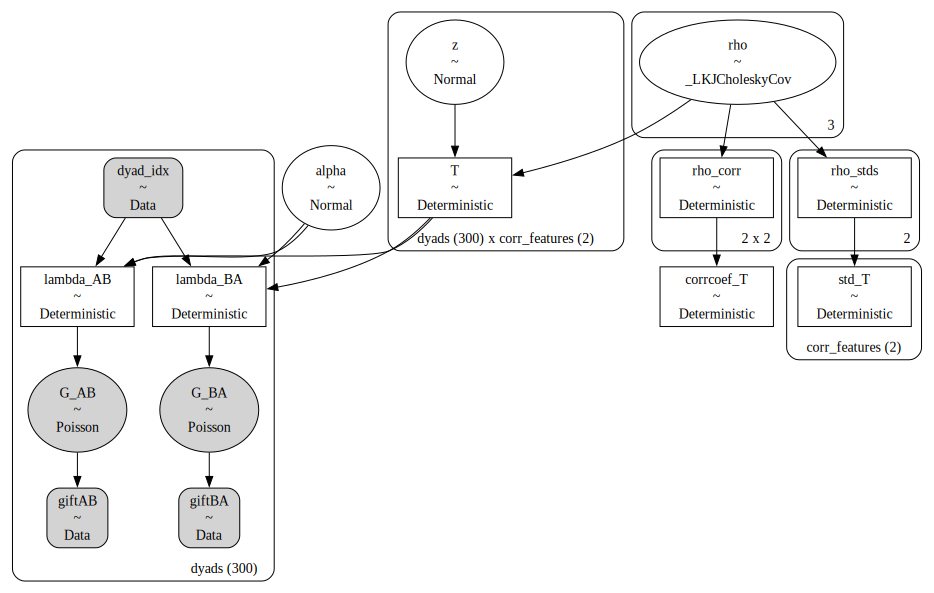

In [117]:
pm.model_to_graphviz(simulated_social_ties_model_c)

In [92]:
az.summary(simulated_social_ties_inference, var_names=['rho_corr', 'rho_stds'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"rho_corr[A, A]",1.000,0.000,1.000,1.000,0.000,0.000,8000.0,8000.0,NaN
"rho_corr[A, B]",0.603,0.188,0.262,0.927,0.004,0.003,1766.0,3044.0,1.0
"rho_corr[B, A]",0.603,0.188,0.262,0.927,0.004,0.003,1766.0,3044.0,1.0
"rho_corr[B, B]",1.000,0.000,1.000,1.000,0.000,0.000,7984.0,7907.0,1.0
rho_stds[A],0.607,0.106,0.411,0.810,0.002,0.001,3040.0,4036.0,1.0
rho_stds[B],0.661,0.093,0.484,0.832,0.001,0.001,3961.0,5695.0,1.0


In [65]:
# The non centered version
def fit_social_ties_model_nc(data, eta=4):

    # data prep and coords
    DYAD_ID, DYAD = pd.factorize([str(d) for d in dyads], sort=True)
    CORR_FEATURES = ['A', 'B']
    n_correlated_features = len(CORR_FEATURES)
    coords = {"dyads": DYAD, "corr_features": CORR_FEATURES, "corr_features_bis": CORR_FEATURES}

    with pm.Model(coords=coords) as model:

            # Data
            dyad_idx = pm.Data("dyad_idx", DYAD_ID, dims="obs_id")
            giftsAB_obs = pm.Data("giftAB", data.giftsAB, dims="obs_id")
            giftsBA_obs = pm.Data("giftBA", data.giftsBA, dims="obs_id")
            
            # Single, global alpha
            alpha = pm.Normal("alpha", 0, 1)
            
            # Single, global sigma
            sigma = pm.Exponential.dist(1)
            chol, corr, stds = pm.LKJCholeskyCov(
                "rho",
                eta=eta,
                n=n_correlated_features,
                sd_dist=sigma
            )
            
            # Record quantities for reporting
            pm.Deterministic("corrcoef_T", corr[0, 1])
            pm.Deterministic("std_T", stds, dims="corr_features")

            z = pm.Normal("z", 0, 1, dims=("dyads", "corr_features"))
            T = pm.Deterministic("T", chol.dot(z.T).T, dims=("dyads", "corr_features"))

            # non-centered
            alpha_bar = pm.Normal("alpha_bar", 0, 1)  # the average district
            alpha_AB = pm.Deterministic("alpha_AB", alpha_bar + T[:, 0], dims='dyads')
            alpha_BA = pm.Deterministic("alpha_BA", alpha_bar + T[:, 1], dims='dyads')
            
            # link functions
            lambda_AB = pm.Deterministic("lambda_AB", pm.math.exp(alpha_AB), dims="obs_id")
            lambda_BA = pm.Deterministic("lambda_BA", pm.math.exp(alpha_BA), dims="obs_id")

            # Likelihood(s)
            G_AB = pm.Poisson("G_AB", lambda_AB, observed=giftsAB_obs, dims="obs_id")
            G_BA = pm.Poisson("G_BA", lambda_BA, observed=giftsBA_obs, dims="obs_id")
        
    
            # sampling
            inference = pm.sample(tune=2000,
                                draws=2000,
                                chains=4,
                                nuts_sampler='numpyro',
                                        idata_kwargs={
                                            "dims": {
                                                "rho_stds": ["corr_features"],
                                                "rho_corr": ["corr_features", "corr_features_bis"]
                                                }
                                            },
                                target_accept=.9)
    return model, inference

In [97]:
simulated_social_ties_model_nc, simulated_social_ties_inference_nc = fit_social_ties_model_nc(simulated_gifts, eta=2)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

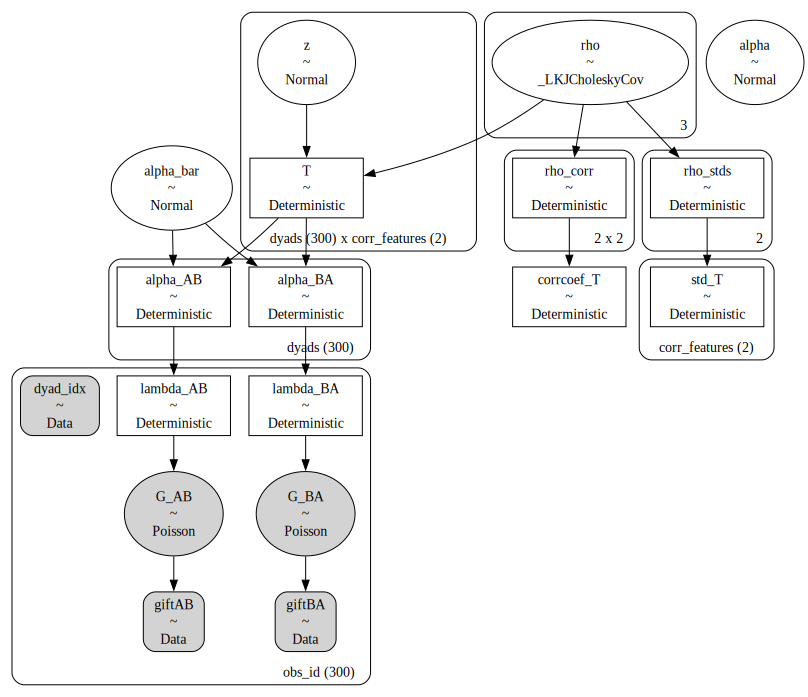

In [67]:
pm.model_to_graphviz(simulated_social_ties_model_nc)

In [98]:
az.summary(simulated_social_ties_inference_nc, var_names=['rho_corr', 'rho_stds'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"rho_corr[A, A]",1.000,0.000,1.000,1.000,0.000,0.000,8000.0,8000.0,NaN
"rho_corr[A, B]",0.606,0.190,0.276,0.948,0.005,0.004,1474.0,2139.0,1.0
"rho_corr[B, A]",0.606,0.190,0.276,0.948,0.005,0.004,1474.0,2139.0,1.0
"rho_corr[B, B]",1.000,0.000,1.000,1.000,0.000,0.000,7910.0,7444.0,1.0
rho_stds[A],0.609,0.104,0.422,0.811,0.002,0.001,2978.0,4159.0,1.0
rho_stds[B],0.662,0.092,0.483,0.827,0.002,0.001,3452.0,5562.0,1.0


In [70]:
az.summary(simulated_social_ties_inference, var_names=['rho_corr', 'rho_stds'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"rho_corr[A, A]",1.000,0.000,1.000,1.000,0.000,0.000,8000.0,8000.0,NaN
"rho_corr[A, B]",0.606,0.189,0.253,0.938,0.005,0.004,1372.0,2519.0,1.0
"rho_corr[B, A]",0.606,0.189,0.253,0.938,0.005,0.004,1372.0,2519.0,1.0
"rho_corr[B, B]",1.000,0.000,1.000,1.000,0.000,0.000,8234.0,7919.0,1.0
rho_stds[A],0.605,0.104,0.397,0.789,0.002,0.002,2349.0,3440.0,1.0
rho_stds[B],0.661,0.092,0.483,0.829,0.002,0.001,3461.0,5583.0,1.0


### Posterior Ties

In [16]:
def plot_posterior_reciprocity(inference, ax=None):
    az.plot_dist(inference.posterior['corrcoef_T'], ax=ax)
    posterior_mean = inference.posterior['corrcoef_T'].mean().values
    plt.axvline(posterior_mean, label=f'posterior mean={posterior_mean:0.2f}', color='k', linestyle='--')
    plt.xlim([-1, 1])
    plt.xlabel("correlation amongst dyads")
    plt.ylabel("density")
    plt.legend()


def plot_posterior_household_ties(inference, color_friends=False, ax=None):
    T = inference.posterior.mean(dim=('chain', 'draw'))['T']
    T_AB = T[:, 0]
    T_BA = T[:, 1]

    if color_friends:
        colors = ["black", "C4"]
        labels = [None, 'friends']
        for is_friends in [0, 1]:
            mask = FRIENDSHIP == is_friends
            utils.plot_scatter(
                T_AB[mask],
                T_BA[mask],
                color=colors[is_friends],
                alpha=.5,
                label=labels[is_friends]
            )
    else:
        utils.plot_scatter(T_AB, T_BA, color="C0", label="dyadic ties")
        

    plt.xlabel("$T_{AB}$")
    plt.ylabel("$T_{BA}$");
    plt.legend();

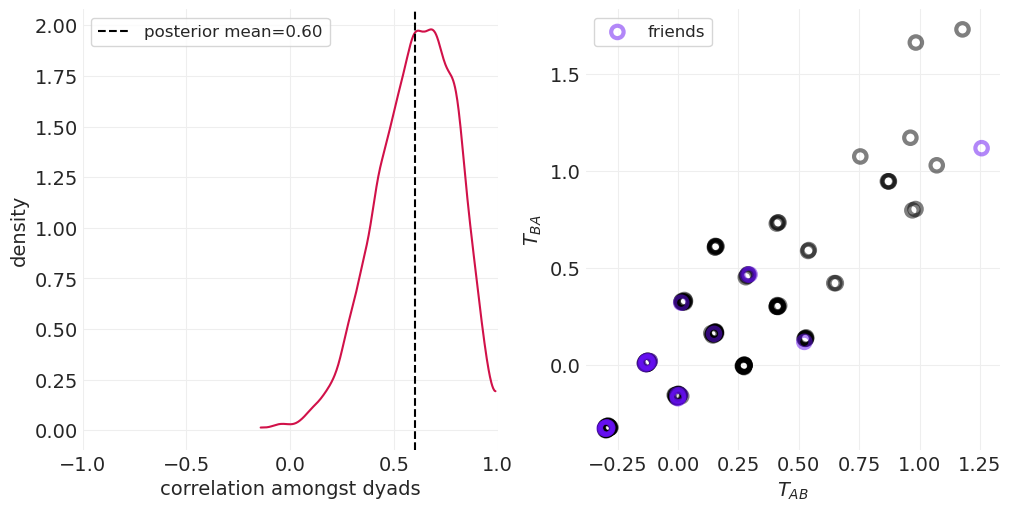

In [96]:
_, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(axs[0])
plot_posterior_reciprocity(simulated_social_ties_inference, ax=axs[0])

plt.sca(axs[1])
plot_posterior_household_ties(simulated_social_ties_inference, color_friends=True, ax=axs[1])

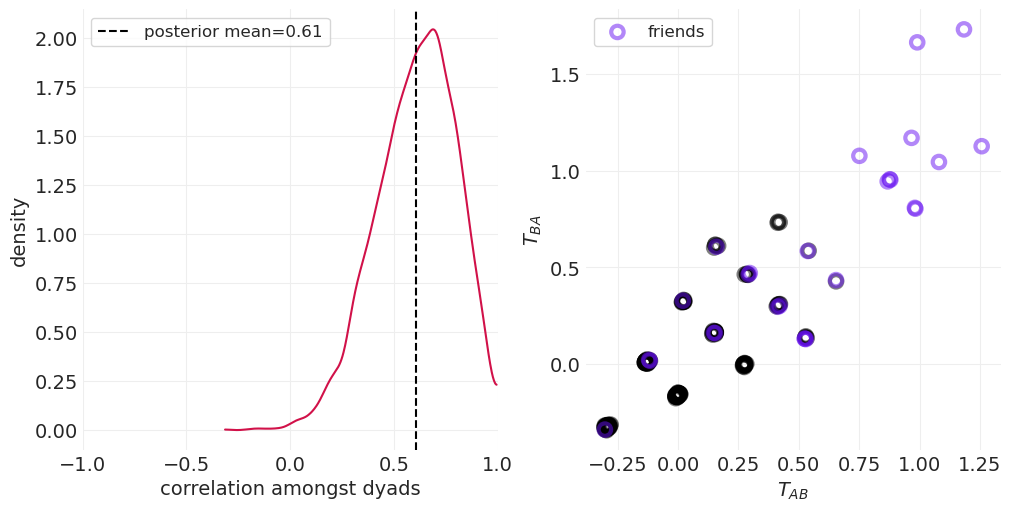

In [99]:
_, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(axs[0])
plot_posterior_reciprocity(simulated_social_ties_inference_nc, ax=axs[0])

plt.sca(axs[1])
plot_posterior_household_ties(simulated_social_ties_inference_nc, color_friends=True, ax=axs[1])

## 4) Analyze Data
Run the model on the real data samples

In [106]:
# watchout works because dyads number in gen model is same as in data set. should improve function
social_ties_model, social_ties_inference = fit_social_ties_model_c(SHARING)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

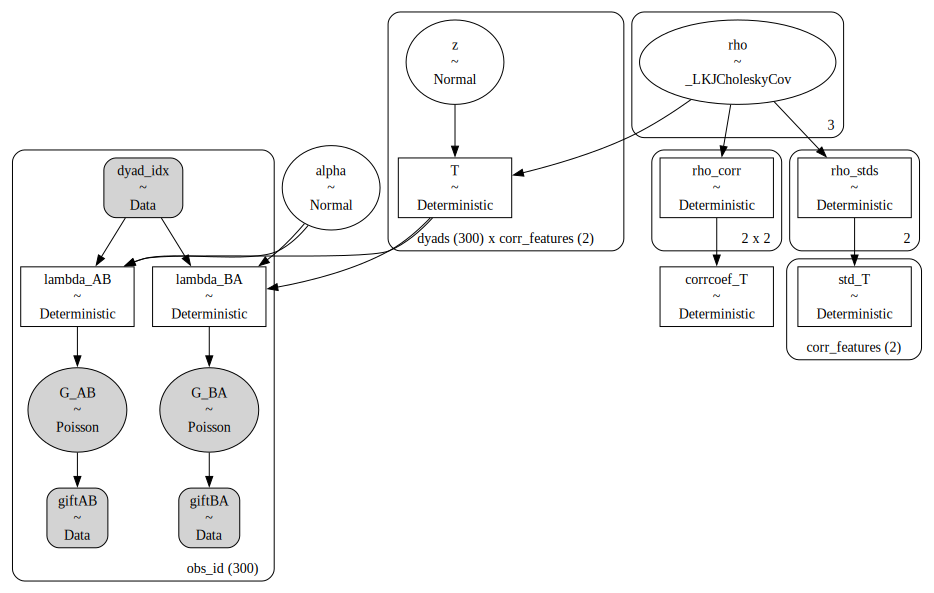

In [107]:
pm.model_to_graphviz(social_ties_model)

### Posterior correlation

In [108]:
az.summary(social_ties_inference, var_names='rho_corr')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"rho_corr[A, A]",1.000,0.000,1.000,1.000,0.000,0.000,8000.0,8000.0,NaN
"rho_corr[A, B]",0.346,0.069,0.218,0.473,0.002,0.002,909.0,1927.0,1.0
"rho_corr[B, A]",0.346,0.069,0.218,0.473,0.002,0.002,909.0,1927.0,1.0
"rho_corr[B, B]",1.000,0.000,1.000,1.000,0.000,0.000,8042.0,7225.0,1.0


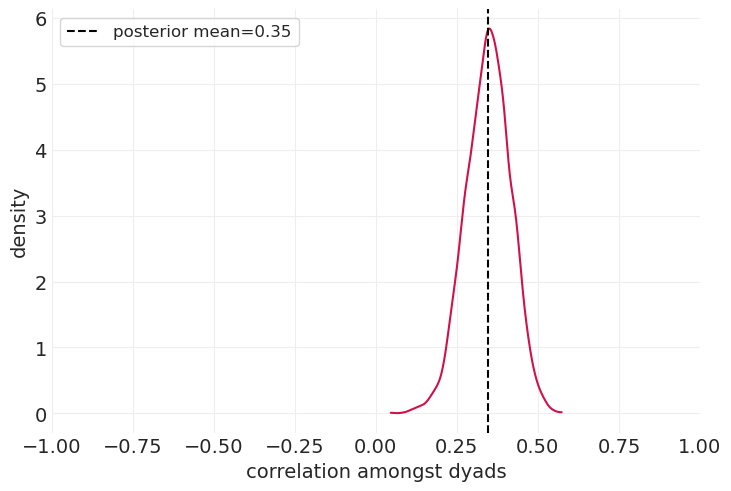

In [109]:
plot_posterior_reciprocity(social_ties_inference)

## Introducing Household Giving/Receiving Confounds
## 2) Generative Model
### Simulate Including Unmeasured Household Wealth
We use the same social ties network, but augment gift-giving behavior based on (unmeasured) household wealth:
- Wealthier households give more
- Poorer households recieve more

In [19]:
SHARING = utils.load_data('KosterLeckie')
SHARING.head()

,hidA,hidB,did,giftsAB,giftsBA,offset,drel1,drel2,drel3,drel4,dlndist,dass,d0125
0,1,2,1,0,4,0.000,0,0,1,0,-2.790,0.000,0
1,1,3,2,6,31,-0.003,0,1,0,0,-2.817,0.044,0
2,1,4,3,2,5,-0.019,0,1,0,0,-1.886,0.025,0
3,1,5,4,4,2,0.000,0,1,0,0,-1.892,0.011,0
4,1,6,5,8,2,-0.003,1,0,0,0,-3.499,0.022,0


In [8]:
from itertools import combinations
np.random.seed(123)

N = 25
dyads = list(combinations(np.arange(N), 2))

# convert to numpy for np.where 
DYADS = np.array(dyads)
N_DYADS = len(DYADS)
giftsAB = np.zeros(N_DYADS)
giftsBA = np.zeros(N_DYADS)

LAMBDA = np.log([0.5, 2])
BETA_WG = 0.5  #  Effect of (standardized) household wealth on giving -> the wealthy give more
BETA_WR = -1   # Effect of household wealth on receiving -> wealthy recieve less

WEALTH = stats.norm.rvs(size=N) # standardized wealth

for ii, (A, B) in enumerate(DYADS):
    lambdaAB = np.exp(LAMBDA[TIES[A, B]] + BETA_WG * WEALTH[A] + BETA_WR * WEALTH[B])
    giftsAB[ii] = stats.poisson(mu=lambdaAB).rvs()
    
    lambdaBA = np.exp(LAMBDA[TIES[B, A]] + BETA_WG * WEALTH[B] + BETA_WR * WEALTH[A])
    giftsBA[ii] = stats.poisson(mu=lambdaBA).rvs()
    
## Put simulation into a dataframe for fitting function
simulated_wealth_gifts = pd.DataFrame(
    {
        "giftsAB": giftsAB.astype(int),
        "giftsBA": giftsBA.astype(int),
        "hidA": DYADS[:, 0],
        "hidB": DYADS[:, 1],
        "did": np.arange(N_DYADS).astype(int)
    }
)

simulated_wealth_gifts

,giftsAB,giftsBA,hidA,hidB,did
0,0,1,0,1,0
1,0,2,0,2,1
2,1,2,0,3,2
3,1,0,0,4,3
4,0,5,0,5,4
...,...,...,...,...,...
295,1,3,21,23,295
296,5,0,21,24,296
297,0,2,22,23,297
298,0,3,22,24,298


In [21]:
# plt.hist(simulated_wealth_gifts.giftsAB, bins=simulated_gifts.giftsAB.max(), width=.25);
# plt.title("Gifting from A to B\n(including household wealth)");

In [22]:
# plt.hist(simulated_wealth_gifts.giftsBA, bins=simulated_gifts.giftsBA.max(), width=.25);
# plt.title("Gifting from B to A\n(including household wealth)");

## 3) Statistical Model

- $G_{A,B}$ - househould $A,B$'s generalized _giving_
- $R_{A,B}$ - househould $A,B$'s generalized _receiving_
- Model Giving and Receiving covariance vian $\text{MVNormal}$

#### Likelihood
$$
\begin{align*}
    G_{AB} &\sim \text{Poisson}(\lambda_{AB}) \\
    G_{BA} &\sim \text{Poisson}(\lambda_{BA}) \\
    \log(\lambda_{AB}) &= \alpha + T_{AB} + G_{A} + R_{B} \\
    \log(\lambda_{BA}) &= \alpha + T_{BA} + G_{B} + R_{A}
\end{align*}
$$

#### Global gift-giving prior
$$
\alpha \sim \text{Normal}(0, 1)
$$

#### Correlated Social Ties prior
$$
\begin{align*}
    \begin{pmatrix}
    T_{AB} \\
    T_{BA}
    \end{pmatrix} &= \text{MVNormal}
    \left( 
        \begin{bmatrix}
            0 \\
            0
        \end{bmatrix},
        \begin{bmatrix}
            \sigma^2 & \rho \sigma^2 \\
            \rho \sigma^2 & \sigma^2
        \end{bmatrix}
    \right) \\
    \rho &\sim \text{LKJCorr}(\eta) \\
    \sigma &\sim \text{Exponential}(1)
\end{align*}
$$

#### Correlated Giving/Recieving prior
$$
\begin{align*}
    \begin{pmatrix}
        G_{A,B} \\
        R_{A,B}
    \end{pmatrix} &= \text{MVNormal}
    \left( 
        \begin{bmatrix}
            0 \\
            0
        \end{bmatrix},
        \textbf{R}_{GR}, \textbf{S}_{GR}
    \right) \\
    \textbf{R}_{GR} &\sim \text{LKJCorr}(\eta) \\
    \textbf{S}_{GR} &\sim \text{Exponential}(1)
\end{align*}
$$

### Fit Wealth Gifting model on simulated data (validation)

In [9]:
# Original models no coords
def fit_giving_receiving_model(data, eta=2):
    n_dyads = len(data)
    n_correlated_features = 2
    
    dyad_id = data.did.values.astype(int)
    household_A_id = data.hidA.values.astype(int)
    household_B_id = data.hidB.values.astype(int)
    
    # Data are 1-indexed
    if np.min(dyad_id) == 1:
        dyad_id -= 1
        household_A_id -= 1
        household_B_id -= 1
        
    n_households = np.max([household_A_id, household_B_id]) + 1

    with pm.Model() as model:
        
        # single, global alpha
        alpha = pm.Normal("alpha", 0, 1)
        
        # Social ties interaction; shared sigma
        sigma_T = pm.Exponential.dist(1)
        chol_T, corr_T, std_T = pm.LKJCholeskyCov(
            "rho_T", eta=eta, n=n_correlated_features, sd_dist=sigma_T
        )
        z_T = pm.Normal("z_T", 0, 1, shape=(n_dyads, n_correlated_features))
        T = pm.Deterministic("T", chol_T.dot(z_T.T).T)
        
        # Giving-receiving interaction; full covariance
        sigma_GR = pm.Exponential.dist(1, shape=n_correlated_features)
        chol_GR, corr_GR, std_GR = pm.LKJCholeskyCov( "rho_GR", 
                                                     eta=eta,
                                                    n=n_correlated_features,
                                                    sd_dist=sigma_GR
                                                    )
        z_GR = pm.Normal("z_GR", 0, 1, shape=(n_households, n_correlated_features))
        GR = pm.Deterministic("GR", chol_GR.dot(z_GR.T).T)

        # link function
        lambda_AB = pm.Deterministic(
            "lambda_AB",
            pm.math.exp(alpha + T[dyad_id, 0] + GR[household_A_id, 0] + GR[household_B_id, 1])
        )
        lambda_BA = pm.Deterministic(
            "lambda_BA",
            pm.math.exp(alpha + T[dyad_id, 1] + GR[household_B_id, 0] + GR[household_A_id, 1])
        )
        
        # Record quantities for reporting
        pm.Deterministic("corrcoef_T", corr_T[0, 1])
        pm.Deterministic("std_T", std_T)
        
        pm.Deterministic("corrcoef_GR", corr_GR[0, 1])
        pm.Deterministic("std_GR", std_GR)

        # likelihood
        G_AB = pm.Poisson("G_AB", lambda_AB, observed=data.giftsAB)
        G_BA = pm.Poisson("G_BA", lambda_BA, observed=data.giftsBA)

        # sampling
        inference = pm.sample(tune=4000,
                              draws=4000,
                              chains=4,
                              nuts_sampler='numpyro',
                              idata_kwargs={'log_likelihood': True},
                              target_accept=.9)
    return model, inference

In [113]:
simulated_gr_model, simulated_gr_inference = fit_giving_receiving_model(simulated_wealth_gifts)

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

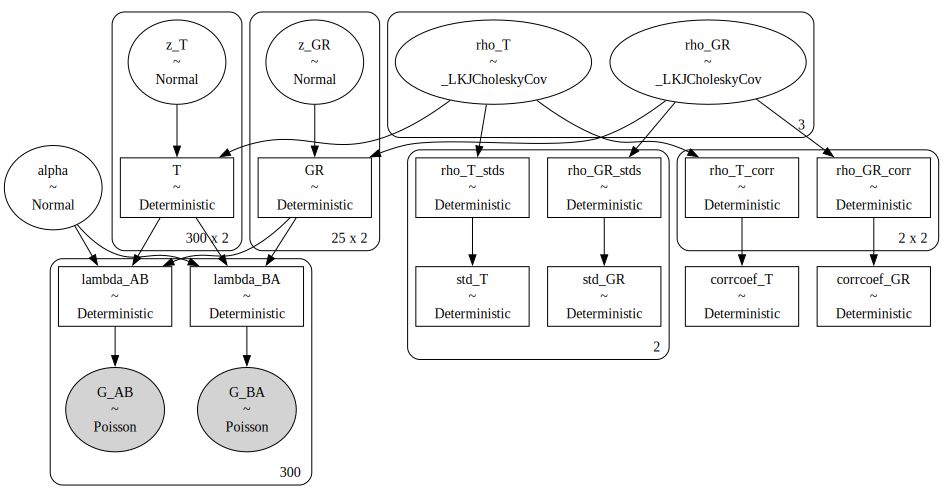

In [114]:
pm.model_to_graphviz(simulated_gr_model)

In [25]:
az.summary(simulated_gr_inference, var_names=['corrcoef_T', 'corrcoef_GR'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
corrcoef_T,0.464,0.268,-0.025,0.926,0.016,0.012,265.0,498.0,1.01
corrcoef_GR,-0.853,0.090,-0.990,-0.691,0.002,0.002,1322.0,1566.0,1.00


In [10]:
# function with model with coordinates
def fit_giving_receiving_model_c(data, eta=2):
    # Number of dyads and features
    n_dyads = len(data)
    n_correlated_features = 2
    
    # Extract columns as numpy arrays
    dyad_id = data.did.values.astype(int)
    household_A_id = data.hidA.values.astype(int)
    household_B_id = data.hidB.values.astype(int)
    
    # Adjust indexing if data are 1-indexed
    if np.min(dyad_id) == 1:
        dyad_id -= 1
        household_A_id -= 1
        household_B_id -= 1
        
    n_households = np.max([household_A_id, household_B_id]) + 1

    # Define correlated features
    CORR_FEATURES = ['A', 'B']

    # Prepare coordinates
    coords = {
        "dyads": np.arange(n_dyads),
        "corr_features": CORR_FEATURES,
        "corr_features_bis": CORR_FEATURES,
        "households": np.arange(n_households)
    }

    with pm.Model(coords=coords) as model:
                    
        # data
        dyad_idx = pm.Data("dyad_idx", dyad_id, dims="dyads")
        household_A_idx = pm.Data("household_A_idx", household_A_id, dims="dyads")
        household_B_idx = pm.Data("household_B_idx", household_B_id, dims="dyads")

        giftsAB_obs = pm.Data("giftsAB", data.giftsAB, dims="dyads")
        giftsBA_obs = pm.Data("giftsBA", data.giftsBA, dims="dyads")

        # Single, global alpha
        alpha = pm.Normal("alpha", 0, 1)
        
        # Social ties interaction; shared sigma
        sigma_T = pm.Exponential.dist(1)
        chol_T, corr_T, std_T = pm.LKJCholeskyCov(
            "rho_T", eta=eta, n=n_correlated_features, sd_dist=sigma_T
        )
        z_T = pm.Normal("z_T", 0, 1, dims=("dyads", "corr_features"))
        T = pm.Deterministic("T", chol_T.dot(z_T.T).T, dims=("dyads", "corr_features"))
        
        # Giving-receiving interaction; full covariance
        sigma_GR = pm.Exponential.dist(1, shape=n_correlated_features)
        chol_GR, corr_GR, std_GR = pm.LKJCholeskyCov(
            "rho_GR", eta=eta, n=n_correlated_features, sd_dist=sigma_GR
        )
        z_GR = pm.Normal("z_GR", 0, 1, dims=("households", "corr_features"))
        GR = pm.Deterministic("GR", chol_GR.dot(z_GR.T).T, dims=("households", "corr_features"))

        # Link function
        lambda_AB = pm.Deterministic(
            "lambda_AB",
            pm.math.exp(alpha + T[dyad_idx, 0] + GR[household_A_idx, 0] + GR[household_B_idx, 1]),
            dims="dyads")
        lambda_BA = pm.Deterministic(
            "lambda_BA",
            pm.math.exp(alpha + T[dyad_idx, 1] + GR[household_B_idx, 0] + GR[household_A_idx, 1]),
            dims="dyads")
        
        # Record quantities for reporting
        pm.Deterministic("corrcoef_T", corr_T[0, 1])
        pm.Deterministic("std_T", std_T, dims="corr_features")
        
        pm.Deterministic("corrcoef_GR", corr_GR[0, 1])
        pm.Deterministic("std_GR", std_GR, dims="corr_features")

        # Likelihood
        G_AB = pm.Poisson("G_AB", lambda_AB, observed=giftsAB_obs, dims="dyads")
        G_BA = pm.Poisson("G_BA", lambda_BA, observed=giftsBA_obs, dims="dyads")

        # Sampling
        inference = pm.sample(
            tune=4000,
            draws=4000,
            chains=4,
            nuts_sampler='numpyro',
            idata_kwargs={'log_likelihood': True},
            target_accept=0.9
        )
        
    return model, inference

In [11]:
simulated_gr_model_c, simulated_gr_inference_c = fit_giving_receiving_model_c(simulated_wealth_gifts)

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

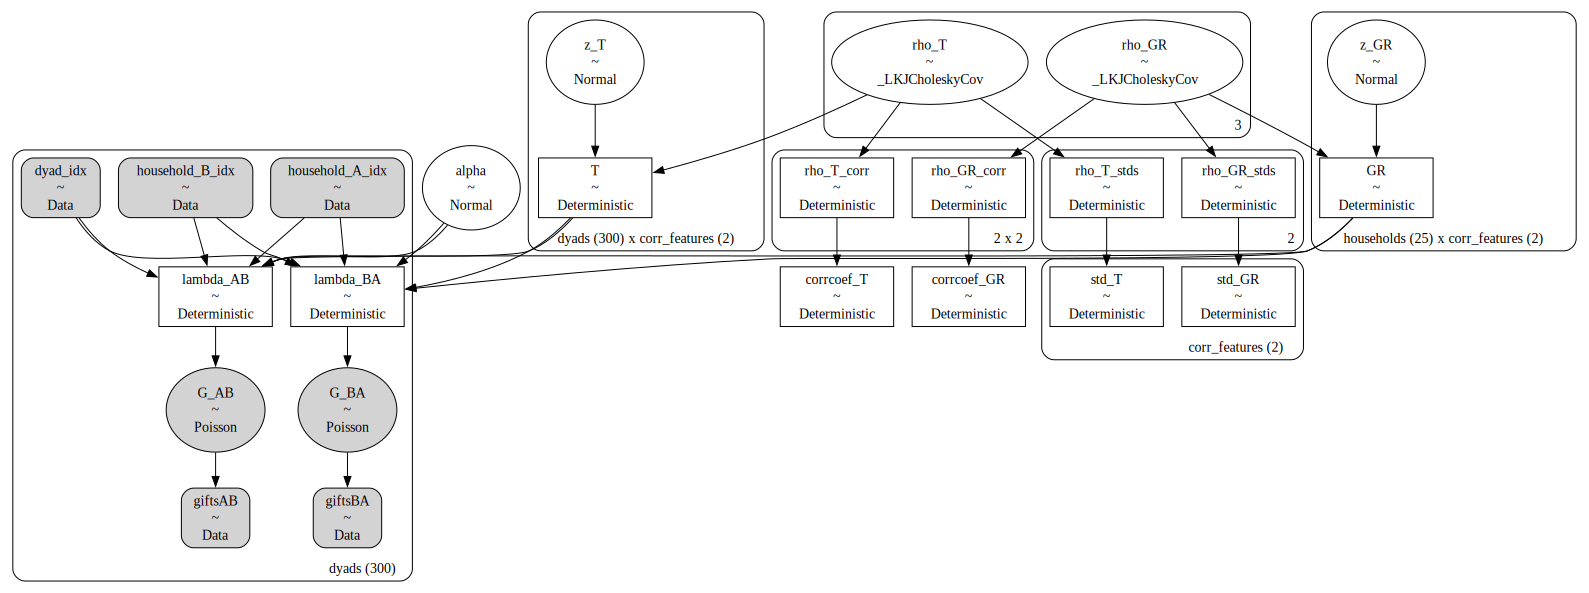

In [12]:
pm.model_to_graphviz(simulated_gr_model_c)

In [13]:
def plot_wealth_gifting_posterior(inference, data_range=None):
    posterior_alpha = inference.posterior['alpha']
    posterior_GR = inference.posterior['GR']

    log_posterior_giving = posterior_alpha + posterior_GR[:, :, :, 0]  # Household A
    log_posterior_receiving = posterior_alpha + posterior_GR[:, :, :, 1]  # Household B

    posterior_receiving = np.exp(log_posterior_giving.mean(dim=('chain', 'draw')))
    posterior_giving = np.exp(log_posterior_receiving.mean(dim=('chain', 'draw')))
    
    # Household giving/receiving
    _, axs = plt.subplots(1, 2, figsize=(10, 5))
    plt.sca(axs[0])
    utils.plot_scatter(
        posterior_receiving,
        posterior_giving,
        color='C0',
        label='households'
    )
    if data_range is None:
        axis_max = np.max(posterior_receiving.values.ravel()) * 1.05
        data_range = (0, axis_max)
    plt.xlabel("giving")
    plt.ylabel("receiving")
    plt.legend();
    plt.plot(data_range, data_range, color='k', linestyle='--')
    plt.xlim(data_range)
    plt.ylim(data_range)
    
    # Giving/receiving correlation distribution
    plt.sca(axs[1])
    az.plot_dist(inference.posterior['corrcoef_GR'], color='C1', plot_kwargs={"linewidth": 3})
    cc_mean = inference.posterior['corrcoef_GR'].mean()
    plt.axvline(cc_mean, color='k', linestyle='--', label=f'posterior mean: {cc_mean:1.2}')
    plt.xlim([-1, 1])
    plt.legend()
    plt.ylabel("density")
    plt.xlabel("correlation, giving-receiving");
    
def plot_dyadic_ties(inference):
    inference = wealth_gifts_inference
    T = inference.posterior.mean(dim=('chain', 'draw'))['T']
    utils.plot_scatter(T[:, 0], T[:, 1], color='C0', label='dyadic ties')
    plt.xlabel("Household A")
    plt.ylabel("Household B")
    plt.legend()

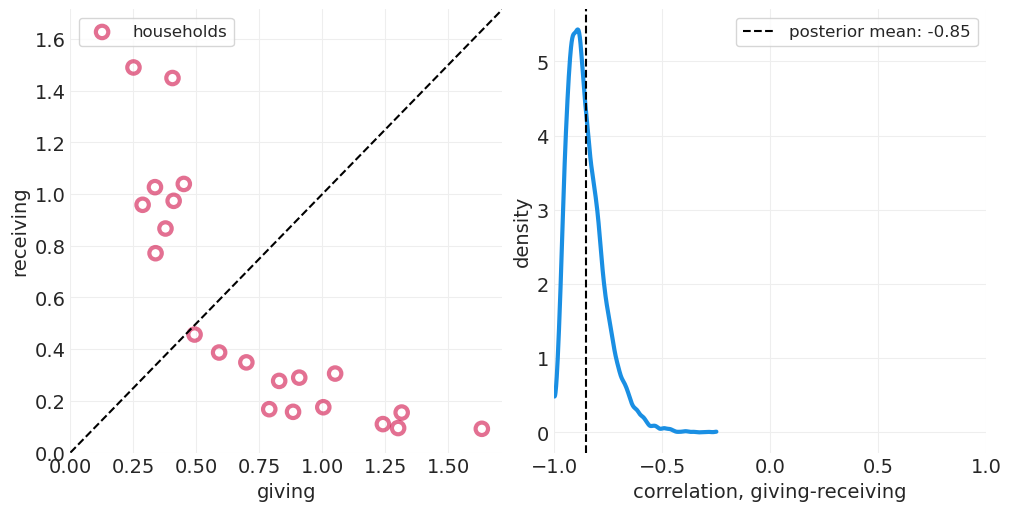

In [14]:
plot_wealth_gifting_posterior(simulated_gr_inference_c)

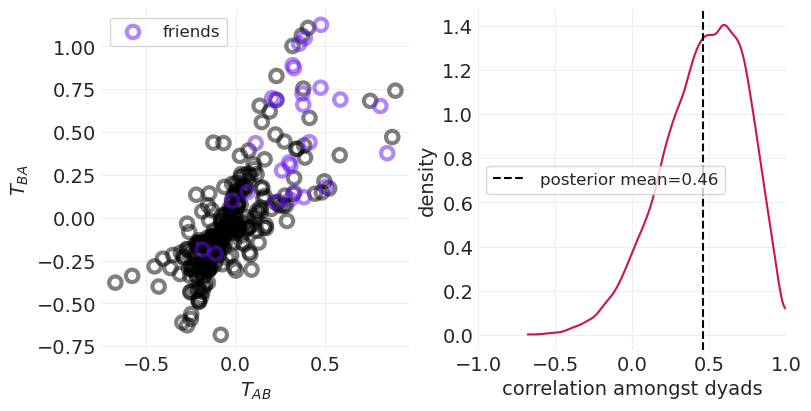

In [17]:
_, axs = plt.subplots(1, 2, figsize=(8, 4))
plt.sca(axs[0])
plot_posterior_household_ties(simulated_gr_inference_c, color_friends=True)

plt.sca(axs[1])
plot_posterior_reciprocity(simulated_gr_inference_c)

### Fit on real data
    

In [20]:
gr_model_c, gr_inference_c = fit_giving_receiving_model_c(SHARING)

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

In [21]:
az.summary(gr_inference_c, var_names=['corrcoef_T', 'corrcoef_GR'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
corrcoef_T,0.940,0.026,0.892,0.985,0.000,0.000,3219.0,5481.0,1.0
corrcoef_GR,-0.519,0.211,-0.888,-0.121,0.003,0.002,3702.0,5168.0,1.0


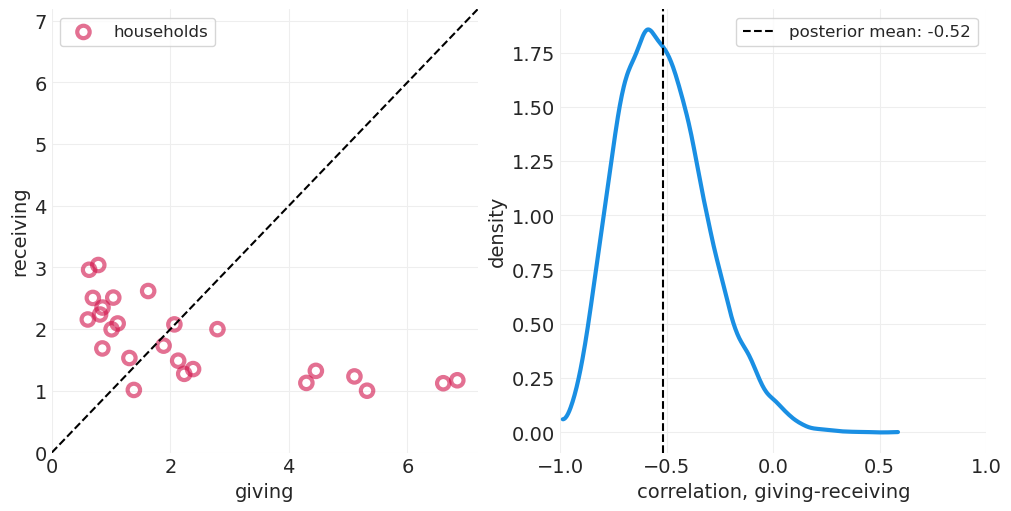

In [23]:
plot_wealth_gifting_posterior(gr_inference_c)

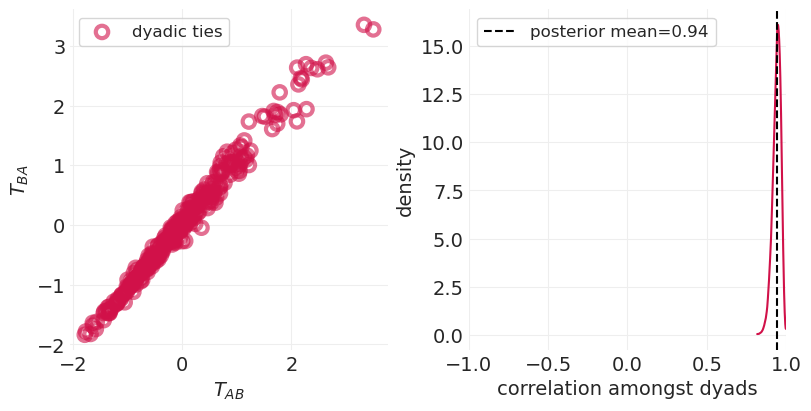

In [24]:
_, axs = plt.subplots(1, 2, figsize=(8, 4))
plt.sca(axs[0])
plot_posterior_household_ties(gr_inference_c)
plt.sca(axs[1])
plot_posterior_reciprocity(gr_inference_c)

### Plot the posterior mean social graph

In [33]:
def plot_posterior_mean_graph(inference, rescale_probs=False, edge_colormap='gray', title=None, **plot_graph_kwargs):
    """Plot the simulated ties graph, weighting each tie connection's edge color by
    a model's posterior mean probability of T_AB.
    """
    T = inference.posterior['T']
    mean_lambda_ties = np.exp(T.mean(dim=('chain', 'draw'))[:, 0])
    _, axs = plt.subplots(1, 2, figsize=(10, 5), width_ratios=[20, 1])
    
    plt.sca(axs[0])
    plt.set_cmap(edge_colormap)
    A, B = np.nonzero(TIES)
    
    G = nx.DiGraph()
    edge_color = []
    for ii, (A, B) in enumerate(DYADS):
        ii, jj = sorted([A, B])
        dyad_idx = np.where((DYADS[:, 0] == A) & (DYADS[:, 1] == B))[0][0].astype(int)
        weight = mean_lambda_ties[dyad_idx]
        
        # include edges that predict one or more social ties
        if weight >= 1:
            G.add_edge(A, B, weight=weight)
            edge_color.append(weight)

    edge_color = np.log(np.array(edge_color))
    utils.plot_graph(G, edge_color=edge_color, pos=TIES_LAYOUT_POSITION, **plot_graph_kwargs)
    plt.title(title)
    
    # Fake axis to hold colorbar
    plt.sca(axs[1])
    axs[1].set_aspect(.0001)
    axs[1].set_visible(False)
    img = plt.imshow(np.array([[edge_color.min(), edge_color.max()]]))
    img.set_visible(False)

    clb = plt.colorbar( orientation="vertical", fraction=0.8, pad=0.1)
    clb.set_label('log(# ties)', rotation=90)

#### Posterior Mean social network from gifting model

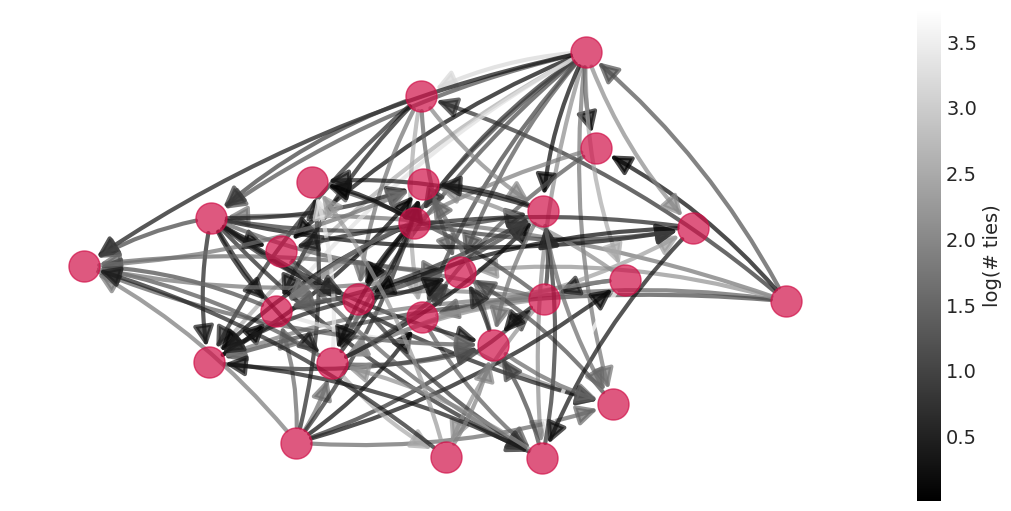

In [34]:
plot_posterior_mean_graph(social_ties_inference)

#### Posterior mean social network for model that also incorporates Wealth

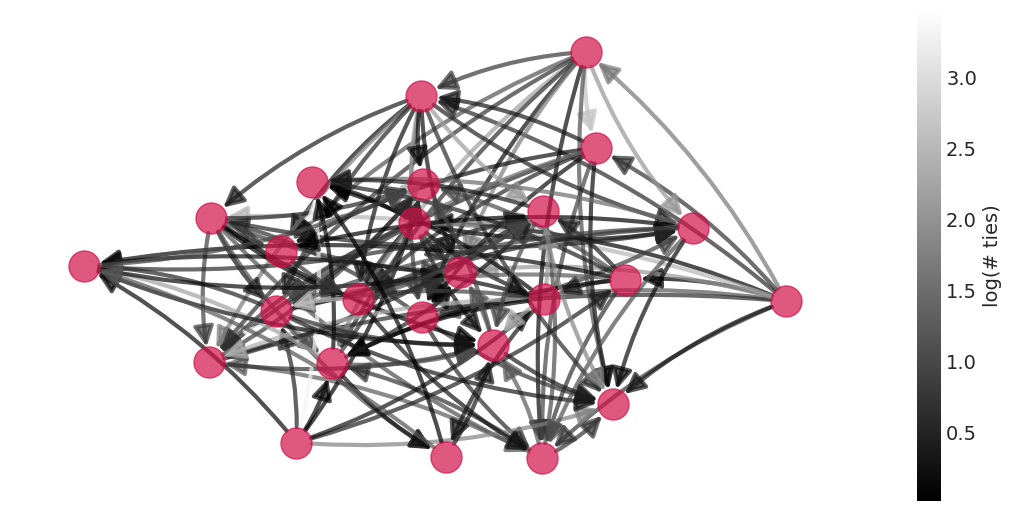

In [35]:
plot_posterior_mean_graph(gr_inference)

## Reminder: Social Networks Don't Exist
- They are abstraction for things we can't measure directly
  - if we can account for all confounds, the network becomes less useful
- Networks models aren't point estimates (though we plot the mean below)
  - Like all other posteriors, any quantities calculated from the graph model (e.g. centrality, degree, etc) should also use distributions

## Including Predictive Household features

Now we'll add predictor featurs to the model. Specifically, we'll add GLM parameters for 
- an association feature $A_{AB}$ for each diad (e.g. friendship), $\beta_A$. 
- the effect of household wealth $W_{A,B}$ on giving, $\beta_G$
- the effect of household wealth $W_{A,B}$ on receiving, $\beta_R$

#### Likelihood
$$
\begin{align*}
    G_{AB} &\sim \text{Poisson}(\lambda_{AB}) \\
    G_{BA} &\sim \text{Poisson}(\lambda_{BA}) \\
    \log(\lambda_{AB}) &= \alpha + \mathcal{T}_{AB} + \mathcal{G}_{A} + \mathcal{R}_{B} \\
    \log(\lambda_{BA}) &= \alpha + \mathcal{T}_{BA} + \mathcal{G}_{B} + \mathcal{R}_{A} \\
    \mathcal{T}_{AB} &= T_{AB} + \beta_A A_{AB} \\
    \mathcal{G}_{A} &= G_{A} + \beta_G W_{A} \\
    \mathcal{R}_{B} &= R_{A} + \beta_R W_{B}
\end{align*}
$$

#### Global  priors
$$
\begin{align*}
    \alpha &\sim \text{Normal}(0, 1) \\
    \beta_{A, G, R} &\sim \text{Normal}(0, 1)
\end{align*}
$$

#### Correlated Social Ties prior
$$
\begin{align*}
    \begin{pmatrix}
        T_{AB} \\
        T_{BA}
    \end{pmatrix} &= \text{MVNormal}
    \left( 
        \begin{bmatrix}
            0 \\
            0
        \end{bmatrix}, 
        \begin{bmatrix}
            \sigma^2 & \rho \sigma^2 \\
            \rho \sigma^2 & \sigma^2
        \end{bmatrix}
    \right) \\
    \rho &\sim \text{LKJCorr}(\eta) \\
    \sigma &\sim \text{Exponential}(1)
\end{align*}
$$

#### Correlated Giving/Recieving prior
$$
\begin{align*}
    \begin{pmatrix}
        G_{A} \\
        R_{A}
    \end{pmatrix} &= \text{MVNormal}
    \left( 
        \begin{bmatrix}
            0 \\
            0
        \end{bmatrix},
        \textbf{R}_{GR}, \textbf{S}_{GR}
    \right) \\
    \textbf{R}_{GR} &\sim \text{LKJCorr}(\eta) \\
    \textbf{S}_{GR} &\sim \text{Exponential}(1)
\end{align*}
$$

#### Add observed confounds variables to simulated dataset

In [25]:
# Add **observed** association feature
simulated_wealth_gifts.loc[:, "association"] = FRIENDSHIP

# Add **observed** wealth feature
simulated_wealth_gifts.loc[:, "wealthA"] = simulated_wealth_gifts.hidA.map({ii: WEALTH[ii] for ii in range(N)})
simulated_wealth_gifts.loc[:, "wealthB"] = simulated_wealth_gifts.hidB.map({ii: WEALTH[ii] for ii in range(N)})

In [37]:
# Original model function
def fit_giving_receiving_features_model(data, eta=2):
    n_dyads = len(data)
    n_correlated_features = 2
    
    dyad_id = data.did.values.astype(int)
    household_A_id = data.hidA.values.astype(int)
    household_B_id = data.hidB.values.astype(int)
    association_AB = data.association.values.astype(float)
    wealthA = data.wealthA.values.astype(float)
    wealthB = data.wealthB.values.astype(float)
    
    # Data are 1-indexed
    if np.min(dyad_id) == 1:
        dyad_id -= 1
        household_A_id -= 1
        household_B_id -= 1
        
    n_households = np.max([household_A_id, household_B_id]) + 1

    with pm.Model() as model:
        
        # Priors
        # single, global alpha
        alpha = pm.Normal("alpha", 0, 1)
        
        # global association and giving-receiving params
        beta_A = pm.Normal("beta_A", 0, 1)
        beta_G = pm.Normal("beta_G", 0, 1)
        beta_R = pm.Normal("beta_R", 0, 1)
        
        # Social ties interaction; shared sigma
        sigma_T = pm.Exponential.dist(1)
        chol_T, corr_T, std_T = pm.LKJCholeskyCov(
            "rho_T", eta=eta, n=n_correlated_features, sd_dist=sigma_T
        )
        z_T = pm.Normal("z_T", 0, 1, shape=(n_dyads, n_correlated_features))
        T = pm.Deterministic("T", chol_T.dot(z_T.T).T)
        
        T_AB = T[dyad_id, 0] + beta_A * association_AB
        T_BA = T[dyad_id, 1] + beta_A * association_AB
        
        # Giving-receiving interaction; full covariance
        sigma_GR = pm.Exponential.dist(1, shape=n_correlated_features)
        chol_GR, corr_GR, std_GR = pm.LKJCholeskyCov(
            "rho_GR", eta=eta, n=n_correlated_features, sd_dist=sigma_GR
        )
        z_GR = pm.Normal("z_GR", 0, 1, shape=(n_households, n_correlated_features))
        GR = pm.Deterministic("GR", chol_GR.dot(z_GR.T).T)
        
        G_A = GR[household_A_id, 0] + beta_G * wealthA
        G_B = GR[household_B_id, 0] + beta_G * wealthB
        
        R_A = GR[household_A_id, 1] + beta_R * wealthA
        R_B = GR[household_B_id, 1] + beta_R * wealthB

        lambda_AB = pm.Deterministic(
            "lambda_AB",
            pm.math.exp(alpha + T_AB + G_A + R_B)
        )
        lambda_BA = pm.Deterministic(
            "lambda_BA",
            pm.math.exp(alpha + T_BA + G_B + R_A)
        )
        
        # Record quantities for reporting
        pm.Deterministic("corrcoef_T", corr_T[0, 1])
        pm.Deterministic("std_T", std_T)
        
        pm.Deterministic("corrcoef_GR", corr_GR[0, 1])
        pm.Deterministic("std_GR", std_GR)
        pm.Deterministic("giving", beta_G)
        pm.Deterministic("receiving", beta_R)

        G_AB = pm.Poisson("G_AB", lambda_AB, observed=data.giftsAB)
        G_BA = pm.Poisson("G_BA", lambda_BA, observed=data.giftsBA)

        inference = pm.sample(
            tune=4000,
            draws=4000,
            chains=4,
            nuts_sampler='numpyro',
            idata_kwargs={'log_likelihood': True},
            target_accept=0.9
        )
    return model, inference

In [38]:
simulated_grf_model, simulated_grf_inference = fit_giving_receiving_features_model(simulated_wealth_gifts)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_A, beta_G, beta_R, rho_T, z_T, rho_GR, z_GR]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [26]:
# updated function with coords
def fit_giving_receiving_features_model_c(data, eta=2):
    n_dyads = len(data)
    n_correlated_features = 2
    
    dyad_id = data.did.values.astype(int)
    household_A_id = data.hidA.values.astype(int)
    household_B_id = data.hidB.values.astype(int)
    association_AB = data.association.values.astype(float)
    wealthA = data.wealthA.values.astype(float)
    wealthB = data.wealthB.values.astype(float)
    
    # Data are 1-indexed
    if np.min(dyad_id) == 1:
        dyad_id -= 1
        household_A_id -= 1
        household_B_id -= 1
        
    n_households = np.max([household_A_id, household_B_id]) + 1

    # Define correlated features
    CORR_FEATURES = ['A', 'B']

    # Prepare coordinates
    coords = {
        "dyads": np.arange(n_dyads),
        "corr_features": CORR_FEATURES,
        "corr_features_bis": CORR_FEATURES,
        "households": np.arange(n_households)
    }

    with pm.Model(coords=coords) as model:
        # Data
        dyad_idx = pm.Data("dyad_idx", dyad_id, dims="dyads")
        household_A_idx = pm.Data("household_A_idx", household_A_id, dims="dyads")
        household_B_idx = pm.Data("household_B_idx", household_B_id, dims="dyads")
        association_AB_obs = pm.Data("association_AB", association_AB, dims="dyads")
        wealthA_obs = pm.Data("wealthA", wealthA, dims="dyads")
        wealthB_obs = pm.Data("wealthB", wealthB, dims="dyads")
        giftsAB_obs = pm.Data("giftsAB", data.giftsAB, dims="dyads")
        giftsBA_obs = pm.Data("giftsBA", data.giftsBA, dims="dyads")

        # Priors
        # Single, global alpha
        alpha = pm.Normal("alpha", 0, 1)
        
        # Global association and giving-receiving params
        beta_A = pm.Normal("beta_A", 0, 1)
        beta_G = pm.Normal("beta_G", 0, 1)
        beta_R = pm.Normal("beta_R", 0, 1)
        
        # Social ties interaction; shared sigma
        sigma_T = pm.Exponential.dist(1)
        chol_T, corr_T, std_T = pm.LKJCholeskyCov(
            "rho_T", eta=eta, n=n_correlated_features, sd_dist=sigma_T
        )
        z_T = pm.Normal("z_T", 0, 1, dims=("dyads", "corr_features"))
        T = pm.Deterministic("T", chol_T.dot(z_T.T).T, dims=("dyads", "corr_features"))
        
        T_AB = T[dyad_idx, 0] + beta_A * association_AB_obs
        T_BA = T[dyad_idx, 1] + beta_A * association_AB_obs
        
        # Giving-receiving interaction; full covariance
        sigma_GR = pm.Exponential.dist(1, shape=n_correlated_features)
        chol_GR, corr_GR, std_GR = pm.LKJCholeskyCov(
            "rho_GR", eta=eta, n=n_correlated_features, sd_dist=sigma_GR
        )
        z_GR = pm.Normal("z_GR", 0, 1, dims=("households", "corr_features"))
        GR = pm.Deterministic("GR", chol_GR.dot(z_GR.T).T, dims=("households", "corr_features"))
        
        G_A = GR[household_A_idx, 0] + beta_G * wealthA_obs
        G_B = GR[household_B_idx, 0] + beta_G * wealthB_obs
        
        R_A = GR[household_A_idx, 1] + beta_R * wealthA_obs
        R_B = GR[household_B_idx, 1] + beta_R * wealthB_obs


        # LInk functions
        lambda_AB = pm.Deterministic(
            "lambda_AB",
            pm.math.exp(alpha + T_AB + G_A + R_B),
            dims="dyads"
        )
        lambda_BA = pm.Deterministic(
            "lambda_BA",
            pm.math.exp(alpha + T_BA + G_B + R_A),
            dims="dyads"
        )
        
        # Record quantities for reporting
        pm.Deterministic("corrcoef_T", corr_T[0, 1])
        pm.Deterministic("std_T", std_T, dims="corr_features")
        
        pm.Deterministic("corrcoef_GR", corr_GR[0, 1])
        pm.Deterministic("std_GR", std_GR, dims="corr_features")
        pm.Deterministic("giving", beta_G)
        pm.Deterministic("receiving", beta_R)

        G_AB = pm.Poisson("G_AB", lambda_AB, observed=giftsAB_obs, dims="dyads")
        G_BA = pm.Poisson("G_BA", lambda_BA, observed=giftsBA_obs, dims="dyads")

        inference = pm.sample(
            tune=4000,
            draws=4000,
            chains=4,
            nuts_sampler='numpyro',
            idata_kwargs={'log_likelihood': True},
            target_accept=0.9
        )
    return model, inference

In [31]:
simulated_grf_model_c, simulated_grf_inference_c = fit_giving_receiving_features_model_c(simulated_wealth_gifts)

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

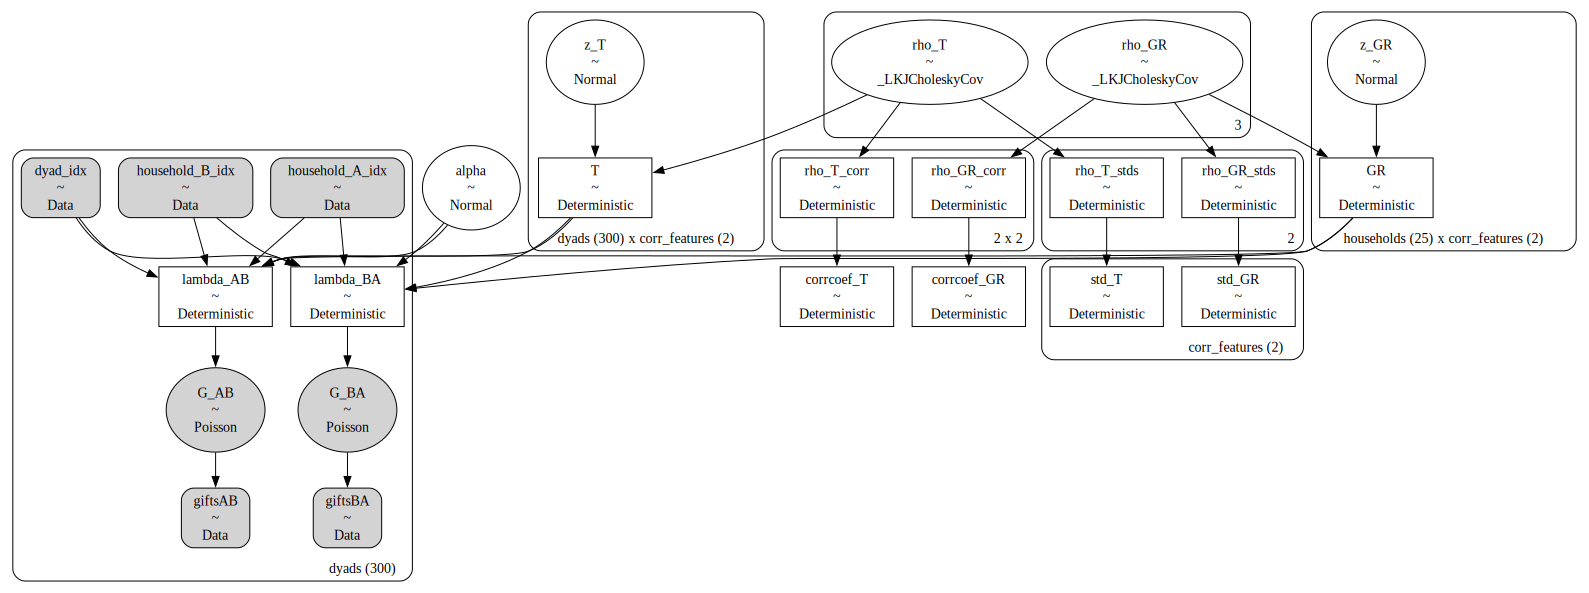

In [30]:
pm.model_to_graphviz(simulated_gr_model_c)

array([[<Axes: title={'center': 'corrcoef_T'}>,
        <Axes: title={'center': 'std_T\nA'}>,
        <Axes: title={'center': 'std_T\nB'}>,
        <Axes: title={'center': 'corrcoef_GR'}>],
       [<Axes: title={'center': 'std_GR\nA'}>,
        <Axes: title={'center': 'std_GR\nB'}>,
        <Axes: title={'center': 'giving'}>,
        <Axes: title={'center': 'receiving'}>]], dtype=object)

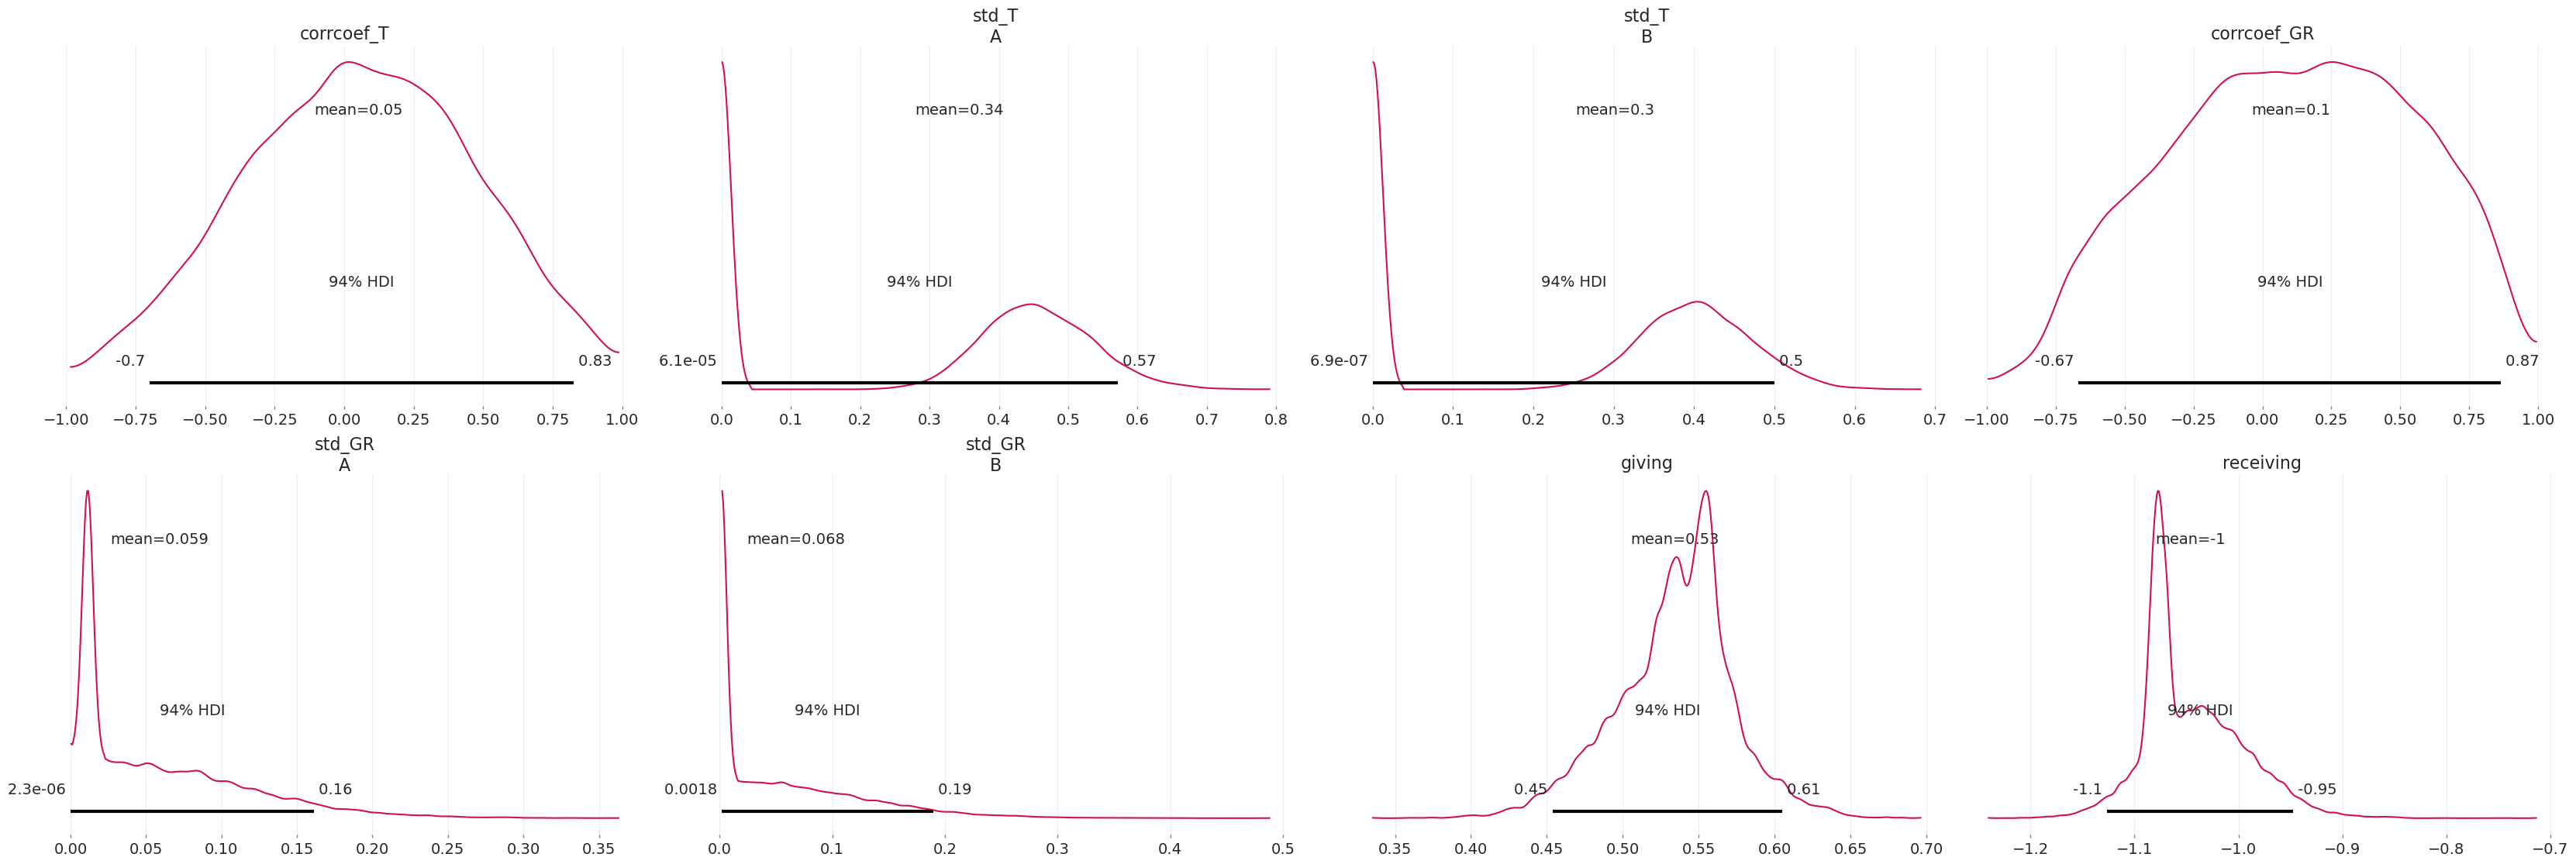

In [29]:
# Summary statistics and posterior plots
az.summary(simulated_grf_inference_c, var_names=["corrcoef_T", "std_T", "corrcoef_GR", "std_GR", "giving", "receiving"])
az.plot_posterior(simulated_grf_inference_c, var_names=["corrcoef_T", "std_T", "corrcoef_GR", "std_GR", "giving", "receiving"])

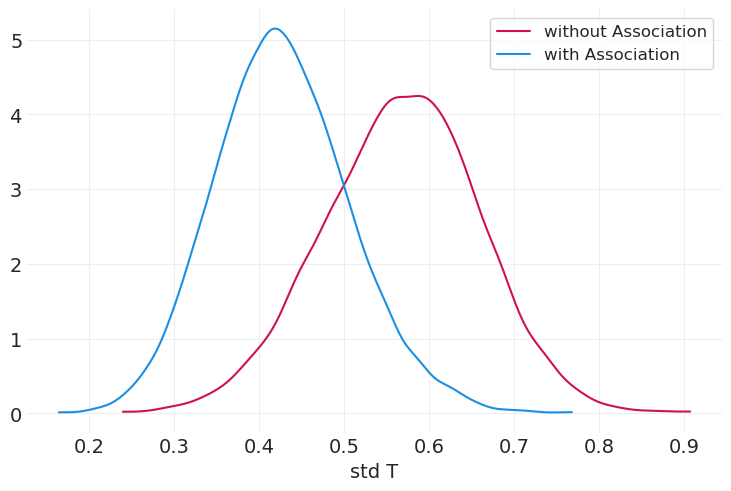

In [39]:
az.plot_dist(simulated_gr_inference.posterior['std_T'], color='C0', label='without Association')
az.plot_dist(simulated_grf_inference.posterior['std_T'], color='C1', label='with Association')
plt.xlabel("std T");

We can see that including parameters for giving and receiving reduces posterior standard deviation associated with social ties. This is expected because, we're explaining away more variance with those additional parameters.

### Model coefficients

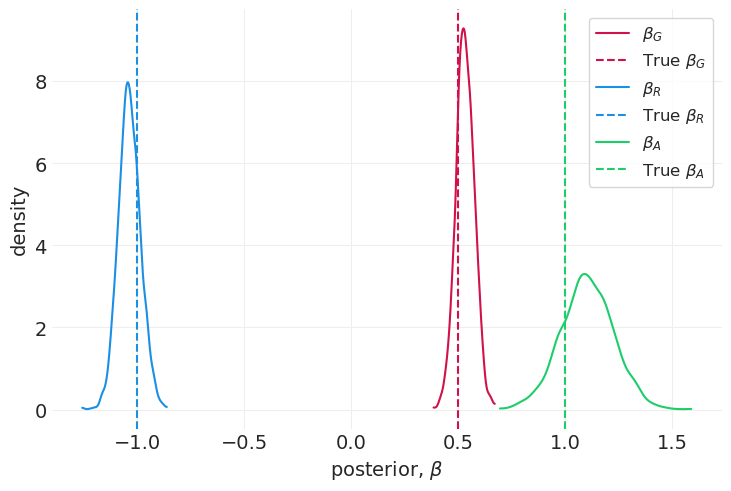

In [40]:
_, ax = plt.subplots()
plt.sca(ax)
posterior = simulated_grf_inference.posterior


az.plot_dist(posterior['beta_G'], color='C0', label='$\\beta_G$')
plt.axvline(BETA_WG, color='C0', linestyle='--', label='True $\\beta_G$')

az.plot_dist(posterior['beta_R'], color='C1', label='$\\beta_R$')
plt.axvline(BETA_WR, color='C1', linestyle='--', label='True $\\beta_R$')

az.plot_dist(posterior['beta_A'], color='C2', label='$\\beta_A$')
plt.axvline(1, color='C2', linestyle='--', label='True $\\beta_A$')

plt.xlabel("posterior, $\\beta$")
plt.ylabel("density");
plt.legend();

Using this model--which is highly aligned with the data simulation--we're able to recover the coefficients from the underlying generative model.
- Association (in this case friendship) gets positive coefficient $\beta_A$. All friendship associations result in giving
- Wealth positively affects giving, $\beta_G$
- Wealth negatively affects receiving $\beta_R$

### Model Comparison
Controlling for the correct confounds provides a better model of the data, in terms of cross-validation scores

In [41]:
az.compare(
    {
        "with confounds": simulated_grf_inference,
        "without confounds": simulated_gr_inference
    },
    var_name='G_AB'
)

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
with confounds,0,-312.680357,40.416593,0.000000,1.000000e+00,18.59661,0.000000,True,log
without confounds,1,-326.362448,55.447187,13.682091,4.618528e-14,18.17911,5.059415,True,log


##### Accounting for the confounding features makes social network abstraction less important

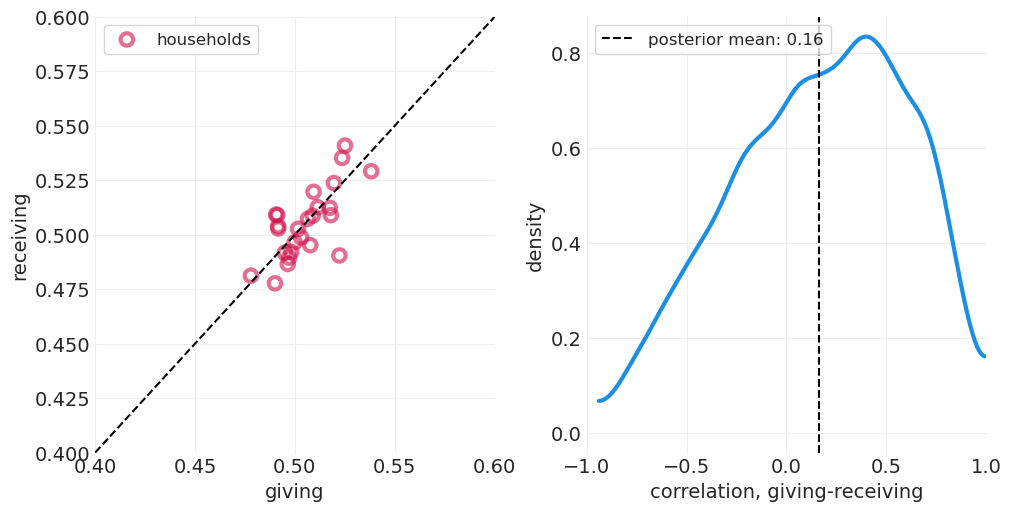

In [42]:
plot_wealth_gifting_posterior(simulated_grf_inference, data_range=(.4, .6))

Giving/receiving is mostly explained by friendship and/or household wealth, so after accounting for those variables, the giving receiving dynamics defined in the dyads has less signal

##### Social ties become more independent when controlling for correct predictors

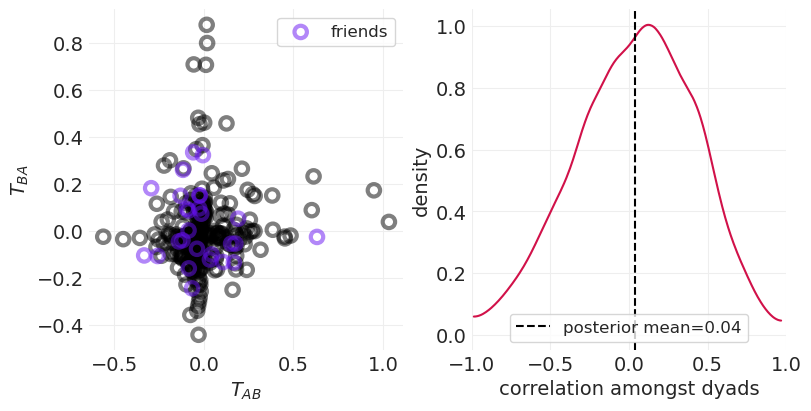

In [43]:
_, axs = plt.subplots(1, 2, figsize=(8, 4))
plt.sca(axs[0])
plot_posterior_household_ties(simulated_grf_inference, color_friends=True)

plt.sca(axs[1])
plot_posterior_reciprocity(simulated_grf_inference)

The x-shape in the joint is indicative of an independent set of variables. m

##### When accounting for confounds, a majority of the connection probabilities are around 0.5
This indicates social ties are more-or-less random after accounting for freindship and wealth

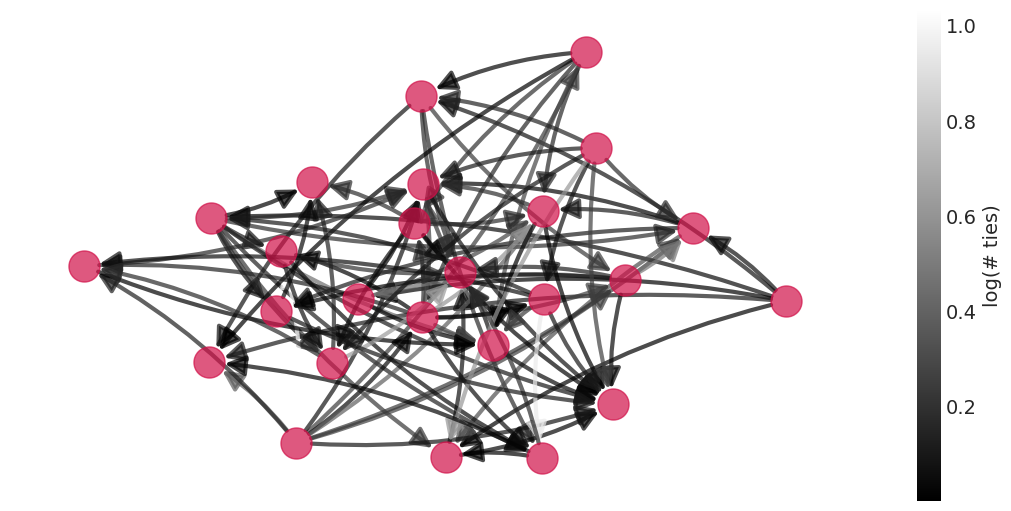

In [44]:
plot_posterior_mean_graph(simulated_grf_inference)

### Fitting Giving-receiving Features Model to Real Data

In the lecture McElreath reports results on the real data, but given the version of the dataset I have in hand, it's somewhat unclear how to move forward.

In [45]:
SHARING.head()

,hidA,hidB,did,giftsAB,giftsBA,offset,drel1,drel2,drel3,drel4,dlndist,dass,d0125
0,1,2,1,0,4,0.000,0,0,1,0,-2.790,0.000,0
1,1,3,2,6,31,-0.003,0,1,0,0,-2.817,0.044,0
2,1,4,3,2,5,-0.019,0,1,0,0,-1.886,0.025,0
3,1,5,4,4,2,0.000,0,1,0,0,-1.892,0.011,0
4,1,6,5,8,2,-0.003,1,0,0,0,-3.499,0.022,0


To fit the model we need to know which columns in the real dataset are associated with

- The association metric $A_{AB}$
- Wealth of Household A $W_A$
- Wealth of Household B $W_B$

Looking at the dataset, it's not entirely clear which columns we should/could associate with each of those variables to replicate the figure in lecture. That said, if we DID know those columns--or how to derive them--it would be easy to fit the model via 

```python
>>> grf_model, grf_inference = fit_giving_receiving_features_model(SHARING)
```

In [46]:
# grf_model, grf_inference = fit_giving_receiving_features_model(SHARING)

## Additional Structure: Triangle Closures
- Relationships tend to come in triads
- **Block models** -- social ties are more common within a social group
  - families
  - classrooms
  - actual city blocks
- Adds additional confounds

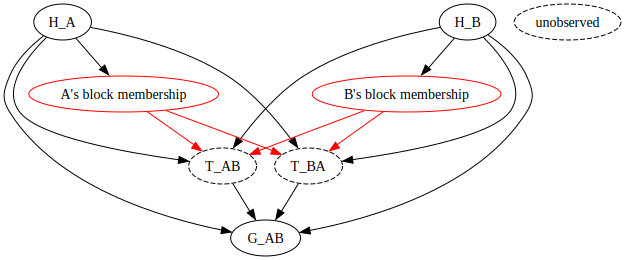

In [47]:
utils.draw_causal_graph(
    edge_list=[
        ("H_A", "G_AB"),
        ("H_B", "G_AB"),
        ("H_A", "T_AB"),
        ("H_B", "T_AB"),
        ("H_A", "T_BA"),
        ("H_B", "T_BA"),
        ("T_AB", "G_AB"),
        ("T_BA", "G_AB"),
        ("H_A", "K_A"),
        ("H_B", "K_B"),
        ("K_A", "T_AB"),
        ("K_B", "T_AB"),
        ("K_A", "T_BA"),
        ("K_B", "T_BA"),
        
    ],
    node_props={
        "T_AB": {"style": "dashed"},
        "T_BA": {"style": "dashed"},
        "K_A": {"color": "red", "label": "A's block membership"},
        "K_B": {"color": "red", "label": "B's block membership"},
        "unobserved": {"style": "dashed"},
    },
    edge_props={
        ("K_A", "T_AB"): {"color": "red"},
        ("K_A", "T_BA"): {"color": "red"},
        ("K_B", "T_AB"): {"color": "red"},
        ("K_B", "T_BA"): {"color": "red"}
    }
)

### Posterior Network is regularized
- Social networks try to express **regularities** in the observations
- Inferred networks are **regularized**

> Blocks and clusters are still discrete subgroups, what about "continuous clusters" like age or spatial distance? The goal of next lecture on Gaussian Processes

In [48]:
def plot_gifting_graph(data, title=None, edge_colormap='gray_r', **plot_graph_kwargs):

    G = nx.DiGraph()
    edge_weights = []
    for ii, (A, B) in enumerate(DYADS):
        row = data.iloc[ii]
        
        if row.giftsAB > 0:
            A_, B_ = A, B
            weight = row.giftsAB
            
        if row.giftsBA > 0:
            A_, B_ = B, A
            weight = row.giftsBA

        G.add_edge(A, B, weight=weight)
        edge_weights.append(weight)
        
    edge_weights = np.array(edge_weights)
    edge_color = np.log(edge_weights)
        
    _, axs = plt.subplots(1, 2, figsize=(10, 5), width_ratios=[20, 1])
    plt.sca(axs[0])
    plt.set_cmap(edge_colormap)
    utils.plot_graph(G, edge_color=edge_color, pos=TIES_LAYOUT_POSITION, **plot_graph_kwargs)
    plt.title(title);
    
    # Fake axis to hold colorbar
    plt.sca(axs[1])
    axs[1].set_aspect(.0001)
    axs[1].set_visible(False)
    img = plt.imshow(np.array([[edge_color.min(), edge_color.max()]]))
    img.set_visible(False)

    clb = plt.colorbar( orientation="vertical", fraction=0.8, pad=0.1)
    clb.set_label('log(# gifts)', rotation=90)


#### Comparing Gifting Observations to Model Trained on those observations
⚠️ The example below is using the simulated data

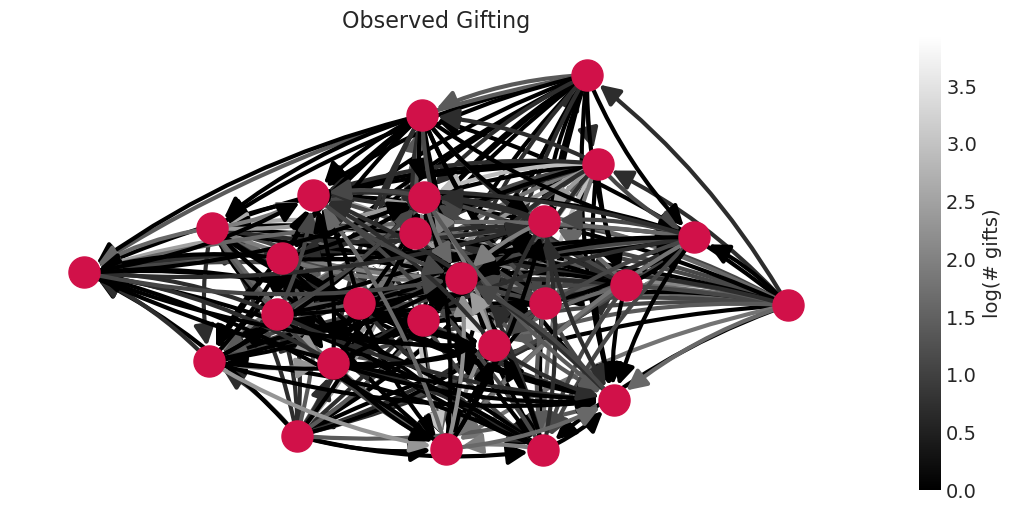

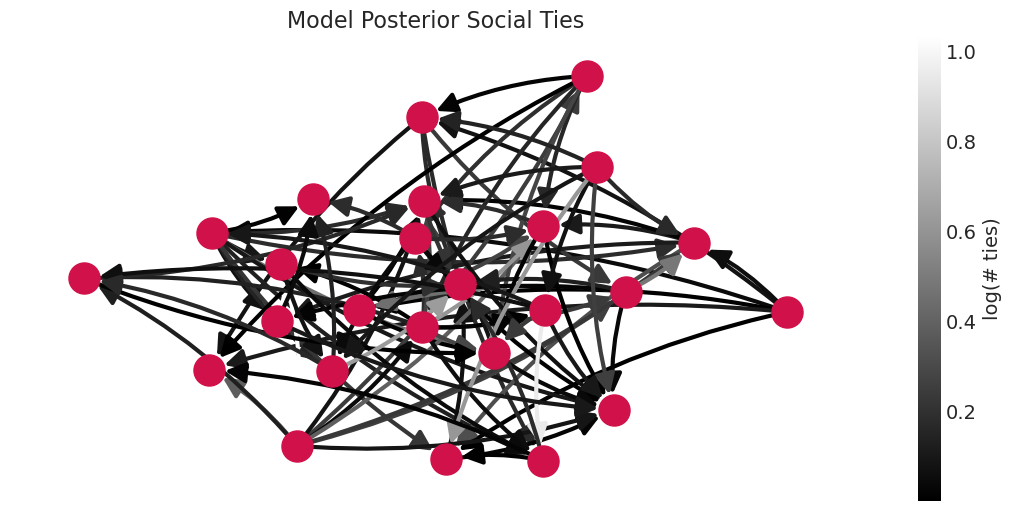

In [49]:
# Data that is modeled
edge_weight_cmap = 'gray'  # switch colorscale to highlight sparsity
plot_gifting_graph(
    simulated_wealth_gifts,
    edge_colormap=edge_weight_cmap,
    alpha=1,
    title = 'Observed Gifting'
)

# Resulting model is sparser
plot_posterior_mean_graph(
    simulated_grf_inference,
    edge_colormap=edge_weight_cmap,
    alpha=1,
    title="Model Posterior Social Ties"
)

The observed gifting network is denser than the social ties network estimated from the data, indicating that the model's pooling is adding regularization (compression) to the network's of social ties.

## Varying effects as technology
- Social nets try to express regularities in observed data
- Inferred nets are thus regularized, capturing those structured regular effects
- What happens when clusters are not discrete?
  - Age, distance, spatial location
  - We need a way to stratify or perform local poolling by "continuous clusters"
    - This is where Gaussian Processes come in next lecture.
    - Allows us to attack problems that require phylogenic and spatial models

# BONUS: Constructed Variables $\neq$ Stratification
- Outcomes that are deterministic functions of e.g.
  - Body Mass Index: $BMI = \frac{mass}{height^2}$
  - "*per capita", "*per unit time"
  - % changes, difference from reference value
- **It's a common misunderstanding that dividing or rescaling by a variable is equivalent to controlling for that variable.**
- Causal inference can provide a means to combine variables in a more principled manner.

### Example: Dividing GDP by population

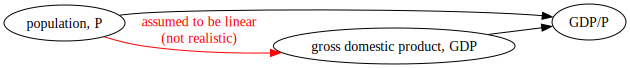

In [50]:
utils.draw_causal_graph(
    edge_list=[
        ("P", "GDP/P"),
        ("GDP", "GDP/P"),
        ("P", "GDP")
    ],
    node_props={
        "P": {"label": "population, P"},
        "GDP": {"label": "gross domestic product, GDP"},
    },
    edge_props={
        ("P", "GDP"): {"color": "red", "label": "assumed to be linear\n(not realistic)", "fontcolor": "red"}
    },
    graph_direction="LR"
)

- makes the assumption that population scales GDP linearly
- dividing by population is not equivalent to stratifying by population

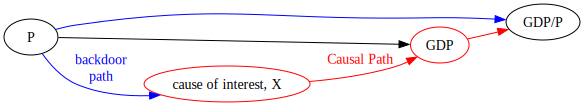

In [51]:
utils.draw_causal_graph(
    edge_list=[
        ("P", "GDP/P"),
        ("GDP", "GDP/P"),
        ("P", "GDP"),
        ("P", "X"),
        ("X", "GDP")
    ],
    node_props={
        "X": {"color": "red", "label": "cause of interest, X"},
        "GDP": {"color": "red"},
    },
    edge_props={
        ("P", "X"): {"color": "blue", "label": "backdoor\npath", "fontcolor": "blue"},
        ("X", "GDP"): {"color": "red", "label": "Causal Path", "fontcolor": "red"},
        ("P", "GDP/P"): {"color": "blue"},
        ("GDP", "GDP/P"): {"color": "red"},
        
    },
    graph_direction="LR"
)

it gets worse, though. In the scenario below, where we want to estimate the causal effect of $X$ on GDP/P, the fork created by $P$ isn't removed by simply calculating GDP/P

### Another Example: Rates

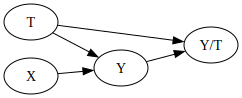

In [52]:
utils.draw_causal_graph(
    edge_list=[
        ("T", "Y/T"),
        ("Y", "Y/T"),
        ("T", "Y"),
        ("X", "Y")
    ],
    graph_direction="LR"
)

- Rates are often calculated as $\frac{\text{\# events}}{\text{unit time}}$  and modeled as outcomes
- Does not consider the varying precision for different amounts of time
  - assuming all Y/T has the same precision, despite larger Y generally having more time to occur, and thus having higher precision
  - collapsing to point estimates removes our ability to talk about uncertainty in rates (e.g. distributions)
  - datapoints with less time/less prcision are given as much credibility to the estimate as data with longer/better precision
- **Division by time does not control for time**
- If rates are the focus of scientific question, **model the counts (e.g. Poisson regression) to estimate the rate parameter**

### Another Example: Difference scores

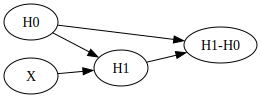

In [53]:
utils.draw_causal_graph(
    edge_list=[
        ("H0", "H1-H0"),
        ("H1", "H1-H0"),
        ("H0", "H1"),
        ("X", "H1")
    ],
    graph_direction="LR"
)

For example the plant growth experiment, where H0 and H1 are the starting and ending heights of the plant, X is the antifungal treatment.

- difference score H1-H0 makes strong assumptions about the effect of H0 on H1, namely that
  - growth effects are constant for all starting heights
  - there is no floor or ceiling effects on plant height
- **need to model H0 on the right side of the GLM (linear regression), as it is a cause of H1**. This is what we did in the plant growth example

## Review: Constructed Variables are Bad
- **arithmetic is not stratification**
- implicity assume fixed functional relationships amongst causes; you should be estimating these functional relationships
- generally ignores uncertainty
- using residuals as new data does not control for variables; don't use in causal inference (though it is often common to do so in predictive settings)


### Adhockery
- adhoc procedures that have intuitive justifications
  - "we expect to see a correlation".
    - Why do you expect to see correlation (make assumptions explicit)?
    - Also, if you don't see a correlation, why does that mean some NULL contingent on that correlation is disproven?
- if an adhoc procedure _does_ work (they sometimes can be correct by chance), it needs to be justified by causal logic and testing
- **Simple rule: Model what you measure**
  - don't try to model new metrics that are derived from measures